In [124]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from statsmodels.tsa.arima.model import ARIMA

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
df = pd.read_parquet('../../ETH-Full-1H.parquet')

In [126]:
df

,Open,High,Low,Close,Volume,Trades
Datetime,,,,,,
2017-09-01 00:00:00,384.79,388.74,384.79,388.74,162.97779,131
2017-09-01 01:00:00,388.69,394.06,387.53,391.37,248.72949,262
2017-09-01 02:00:00,392.88,394.39,389.46,390.88,198.82856,225
2017-09-01 03:00:00,391.70,393.13,390.86,390.86,141.56114,138
2017-09-01 04:00:00,392.65,394.27,387.64,390.33,135.65894,128
...,...,...,...,...,...,...
2023-04-23 19:00:00,1846.76,1852.35,1844.92,1846.49,16550.18290,21648
2023-04-23 20:00:00,1846.49,1852.30,1838.03,1848.89,13113.47550,19445
2023-04-23 21:00:00,1848.88,1859.32,1847.59,1854.66,7855.61330,13824


In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49337 entries, 2017-09-01 00:00:00 to 2023-04-23 23:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    49337 non-null  float64
 1   High    49337 non-null  float64
 2   Low     49337 non-null  float64
 3   Close   49337 non-null  float64
 4   Volume  49337 non-null  float64
 5   Trades  49337 non-null  int32  
dtypes: float64(5), int32(1)
memory usage: 2.4 MB


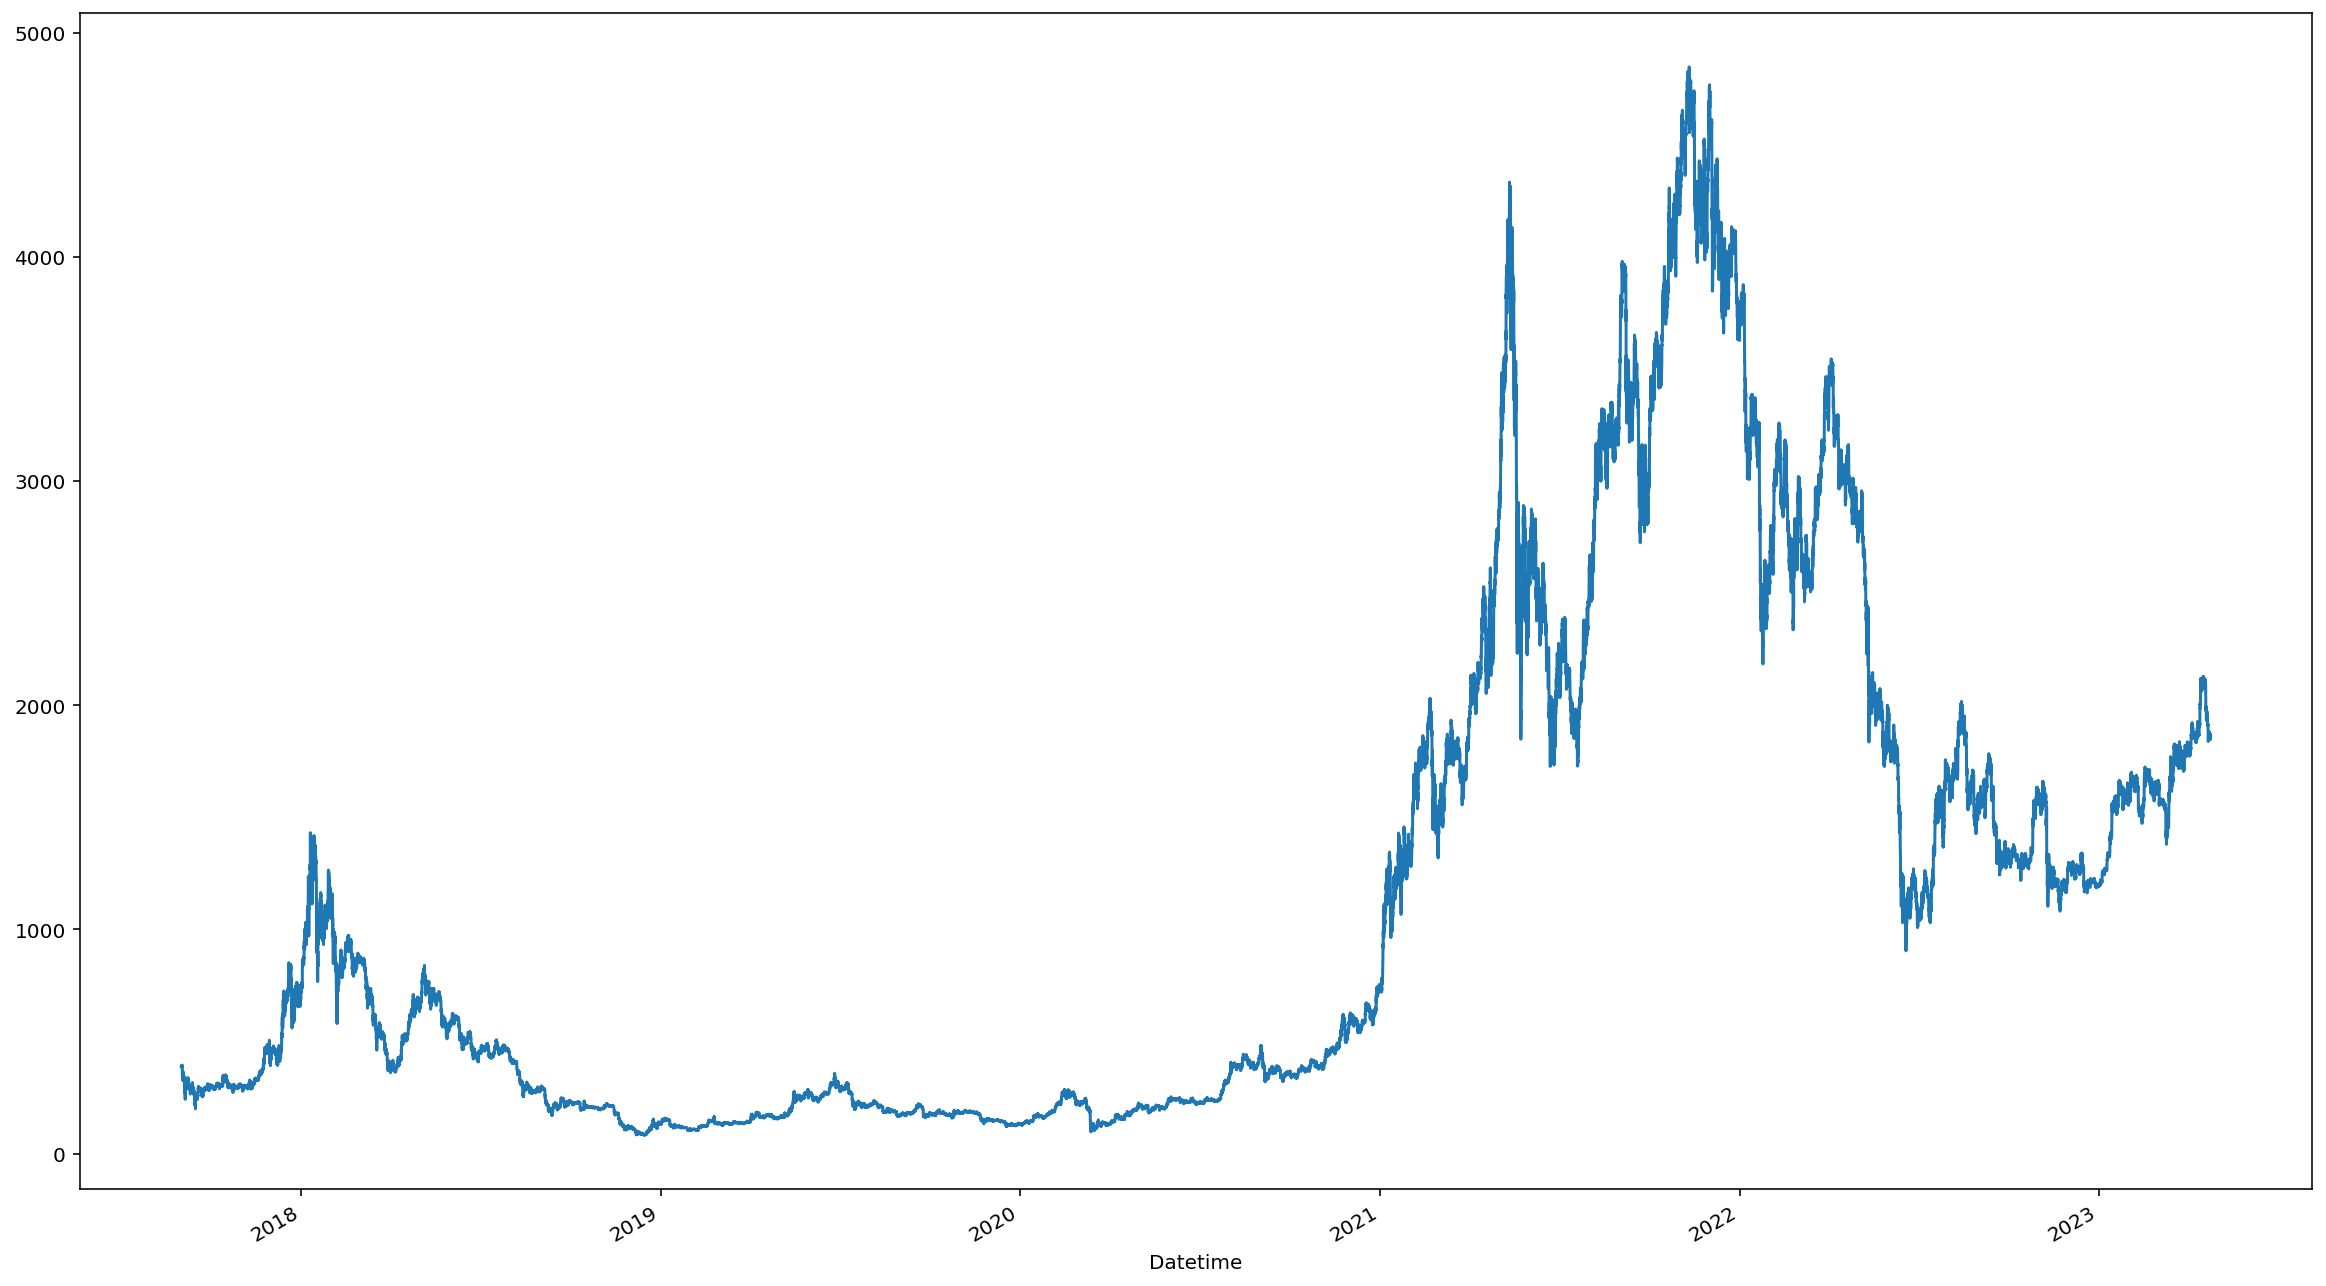

In [128]:
df['Close'].plot(figsize=(20, 12));

### First Difference

In [129]:
df['First_Diff'] = df['Close'].diff()

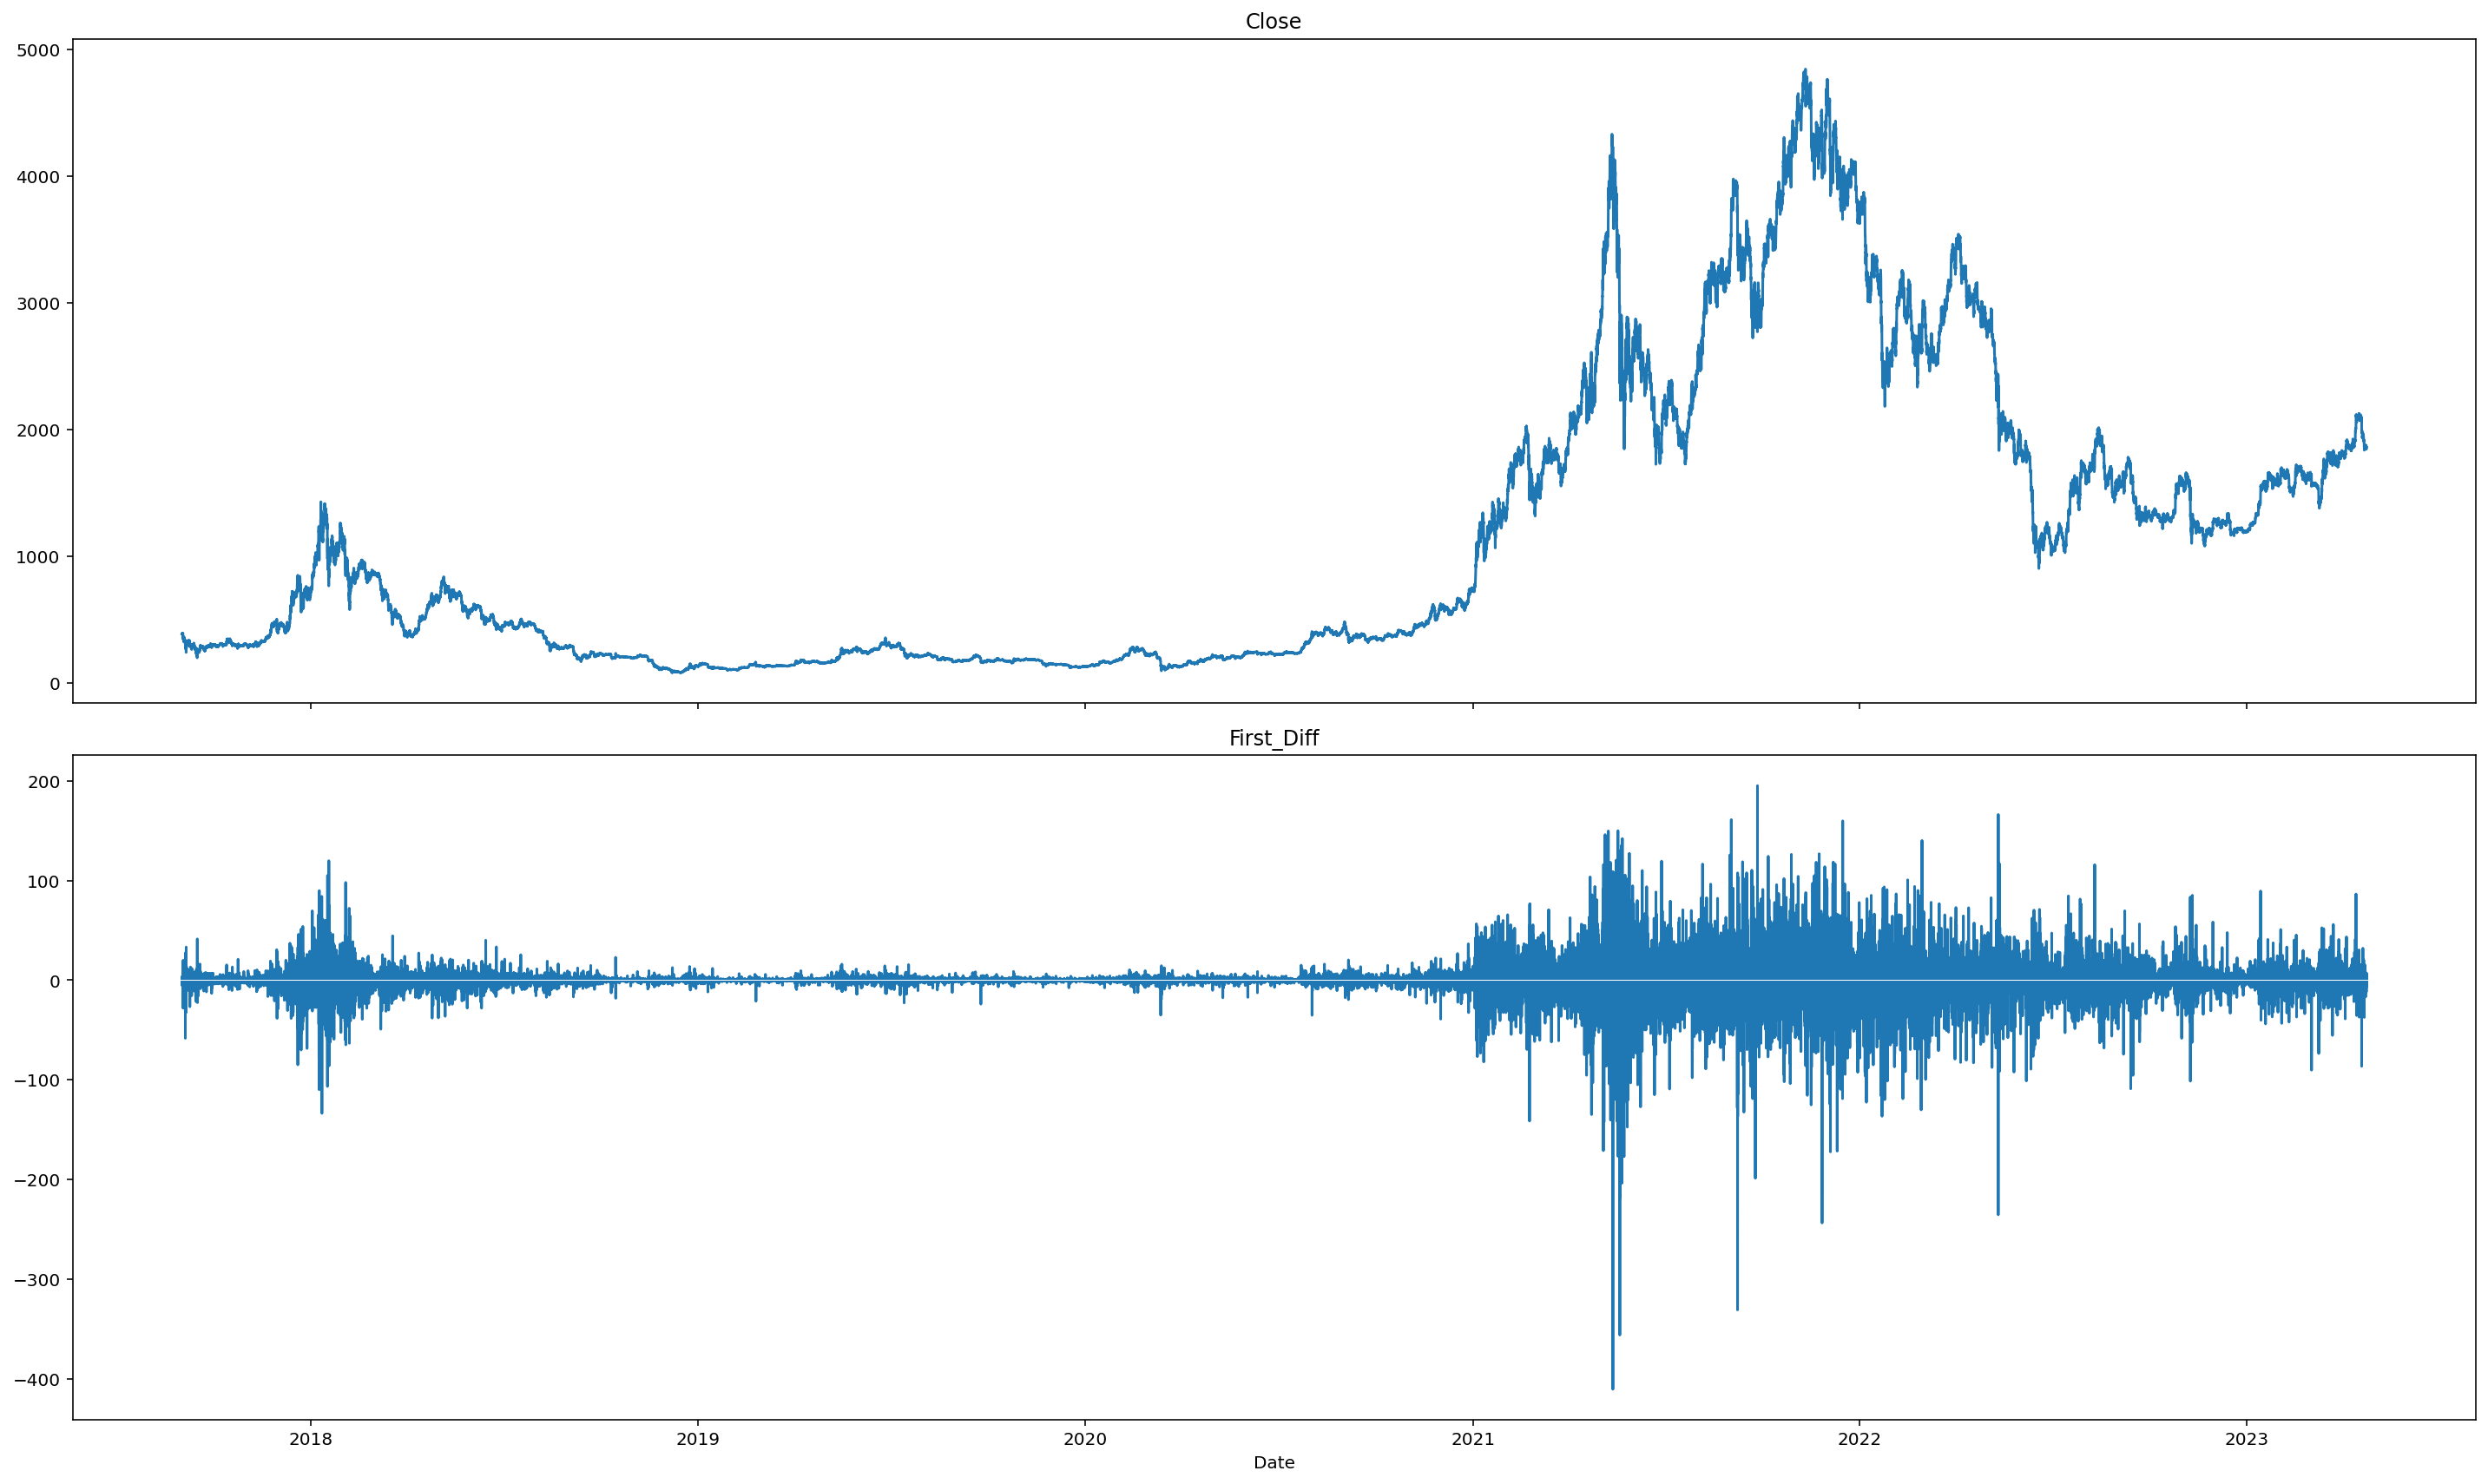

In [130]:
# Create a 3-row, 1-column subplot grid
fig, ax = plt.subplots(2, 1, figsize=(20, 12), sharex=True)

# Convert index and columns to NumPy arrays
index_array = df.index.to_numpy()
first = df['Close'].to_numpy()
second = df['First_Diff'].to_numpy()

# Plot the 'Return' column
ax[0].plot(index_array, first)
# ax[0].axhline(0, color='white', linestyle='-', linewidth=0.5)
ax[0].set_title('Close')

# Plot the 'Return_log' column
ax[1].plot(index_array, second)
ax[1].axhline(0, color='white', linestyle='-', linewidth=0.5)
ax[1].set_title('First_Diff')

# Set the x-axis label for the entire figure
plt.xlabel('Date')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

### Log Price

In [131]:
df['Log_Close'] = np.log(df['Close'])

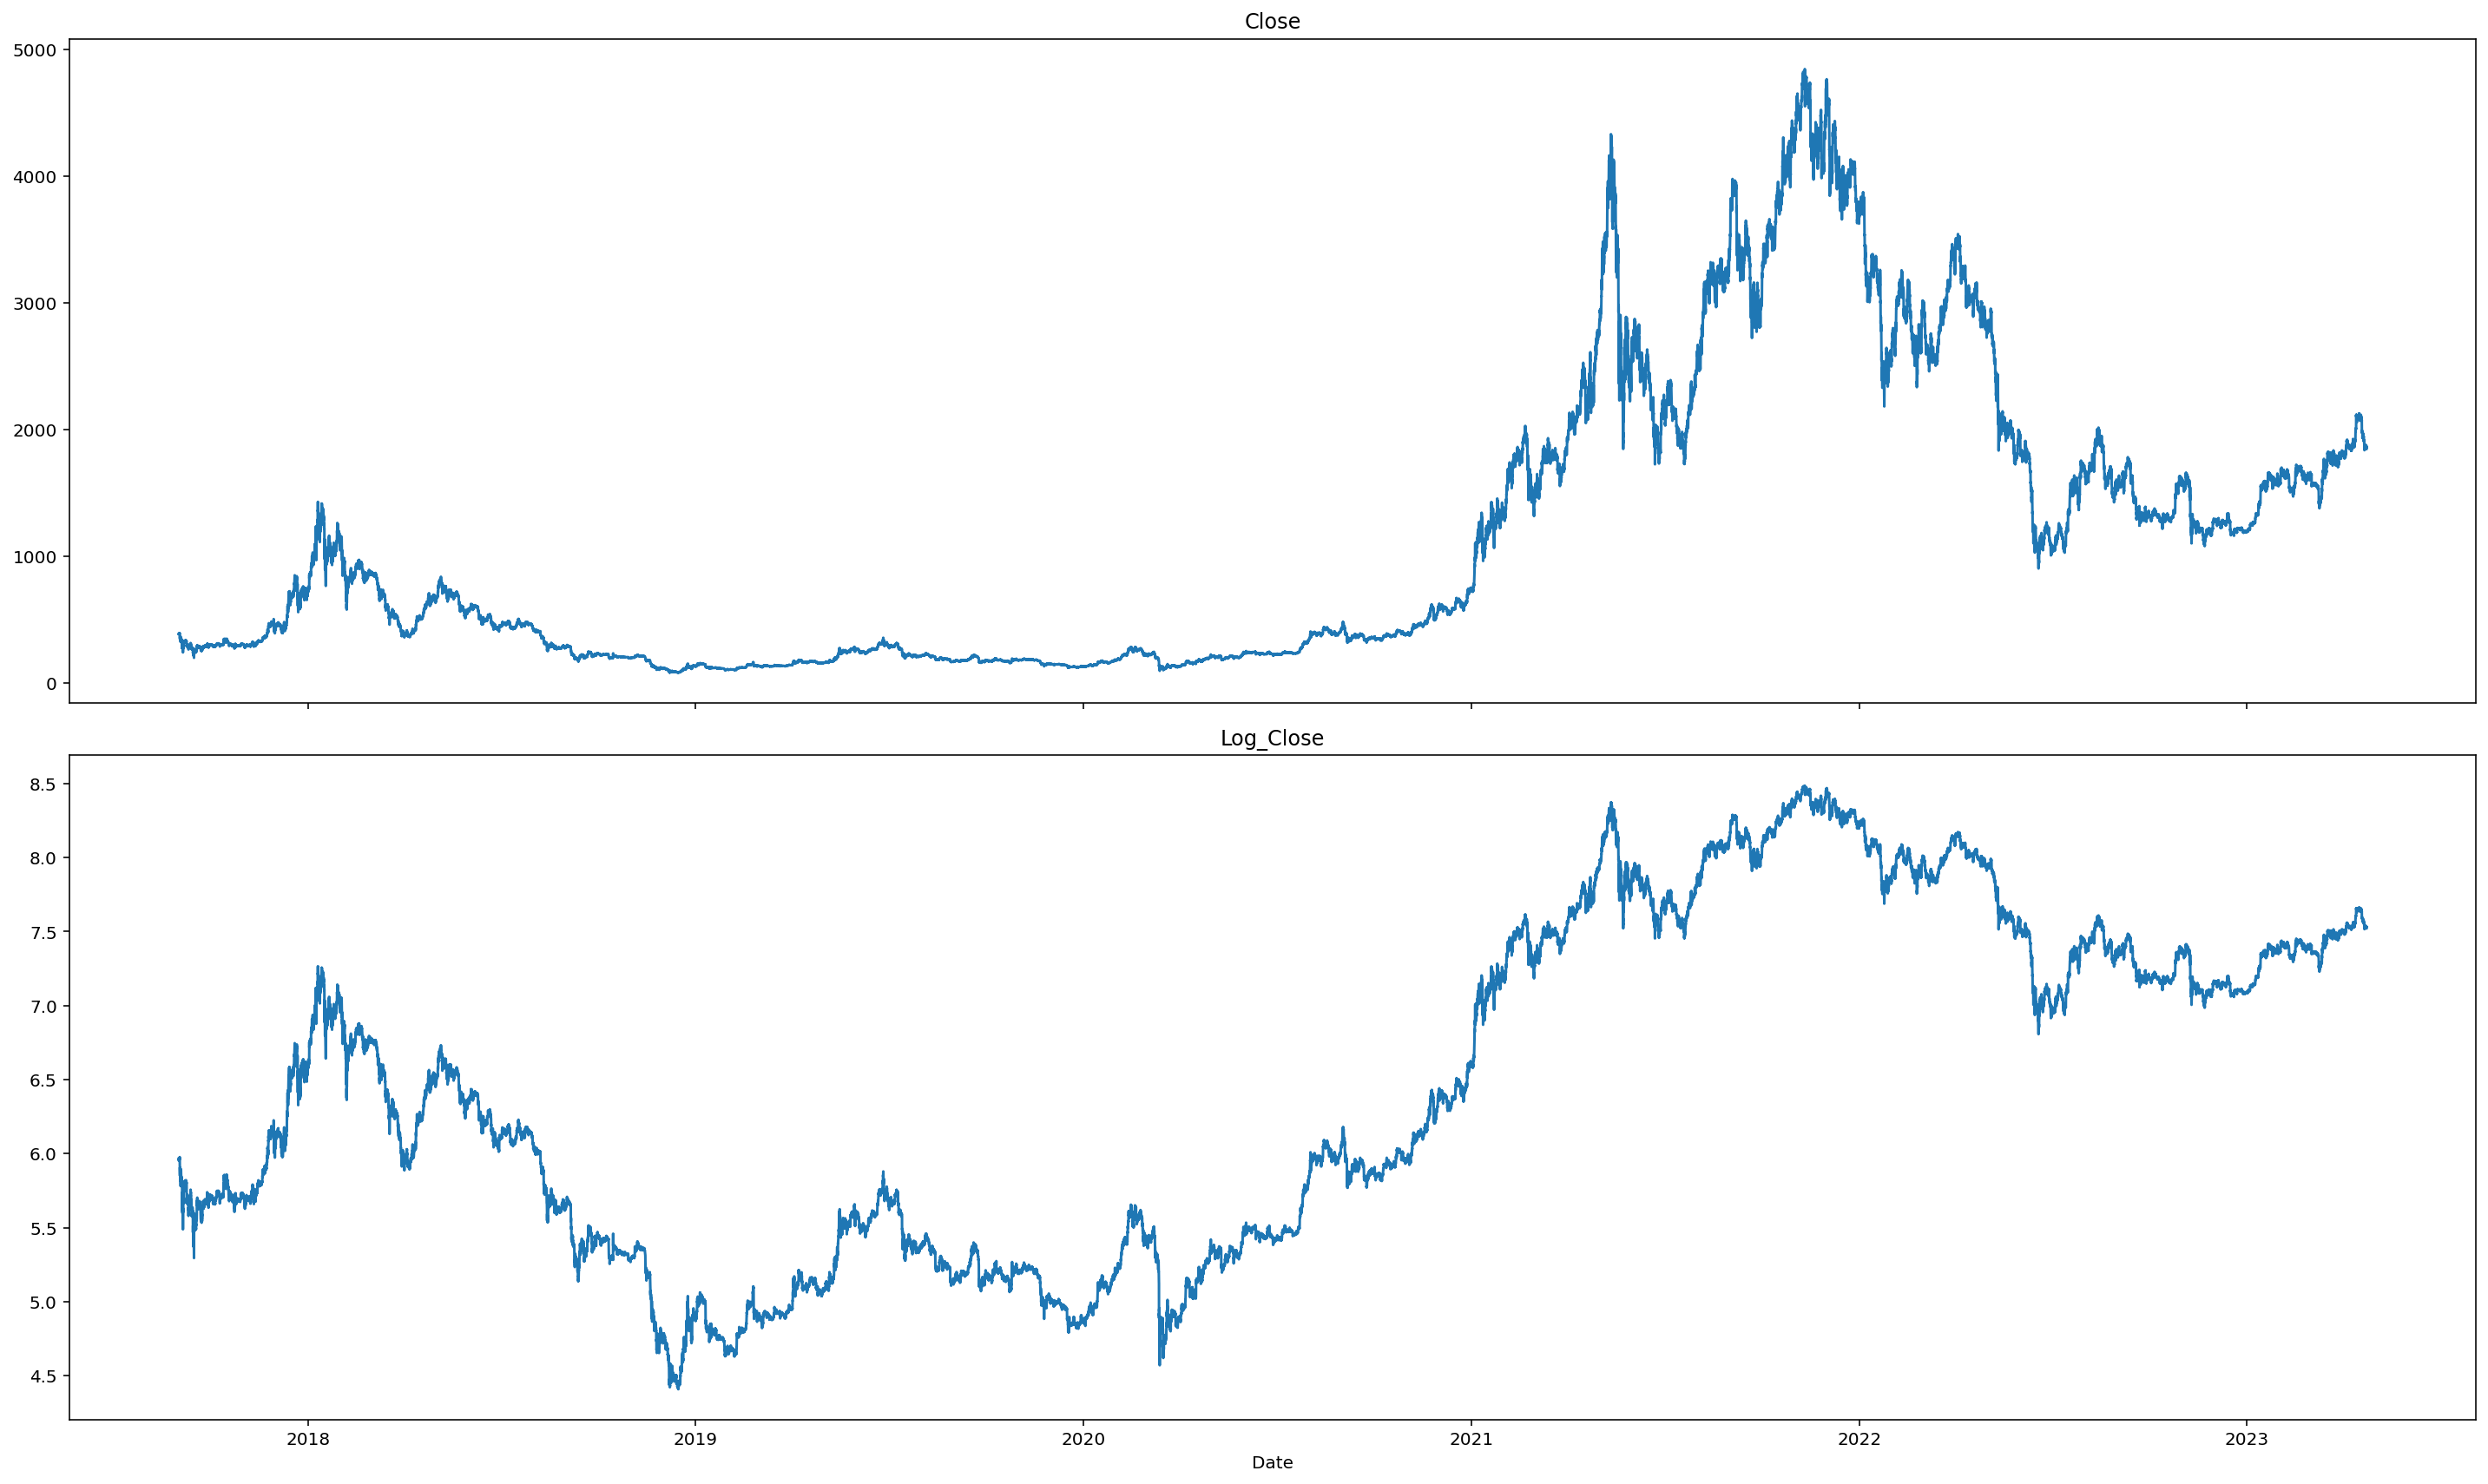

In [132]:
# Create a 3-row, 1-column subplot grid
fig, ax = plt.subplots(2, 1, figsize=(20, 12), sharex=True)

# Convert index and columns to NumPy arrays
index_array = df.index.to_numpy()
first = df['Close'].to_numpy()
second = df['Log_Close'].to_numpy()

# Plot the 'Return' column
ax[0].plot(index_array, first)
# ax[0].axhline(0, color='white', linestyle='-', linewidth=0.5)
ax[0].set_title('Close')

# Plot the 'Return_log' column
ax[1].plot(index_array, second)
# ax[1].axhline(0, color='white', linestyle='-', linewidth=0.5)
ax[1].set_title('Log_Close')

# Set the x-axis label for the entire figure
plt.xlabel('Date')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

Лог цена выглядит симпатичнее

### ARIMA

In [133]:
# df.index.freq = 'H'

In [134]:
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [135]:
# Маски по индексам
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [136]:
arima = ARIMA(train['Close'], order=(1,0,0))

c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [137]:
arima_result = arima.fit()

In [138]:
df.loc[train_idx, 'AR(1)'] = arima_result.predict(start=train.index[0], end=train.index[-1])
# либо вот так на ттренинговой выборке можно получать результаты
# df.loc[train_idx, 'AR(1)'] = arima_result.fittedvalues

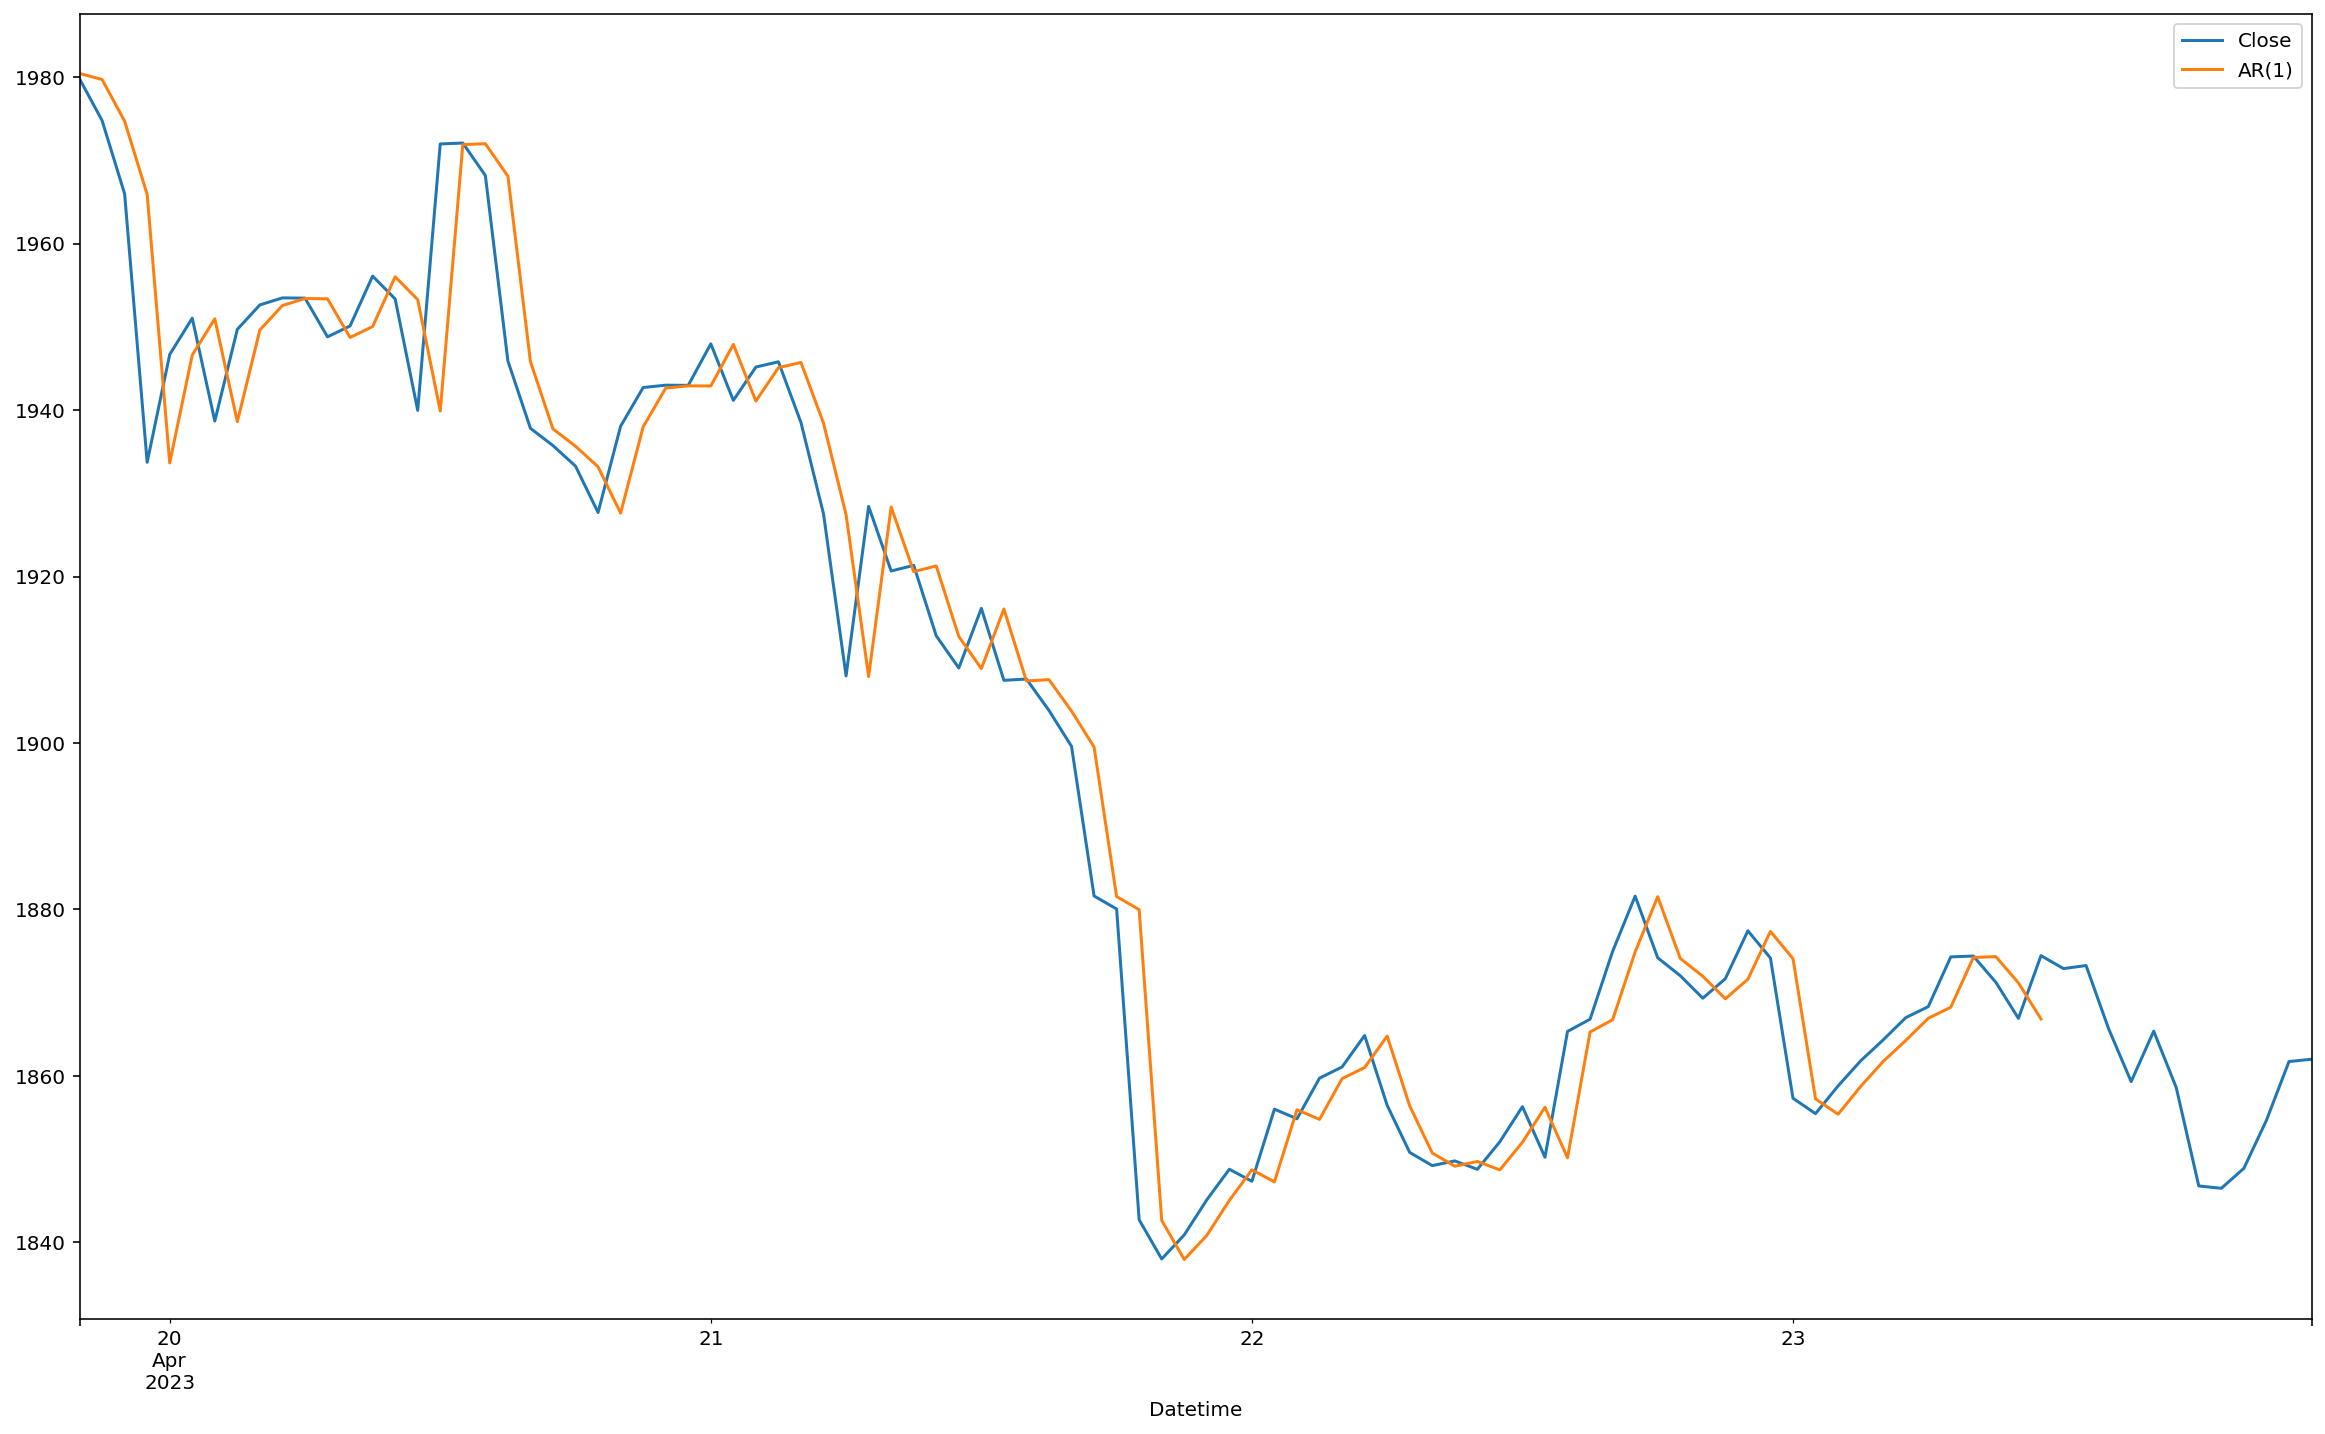

In [139]:
# Последние 100 часов
df[['Close', 'AR(1)']].iloc[-100:].plot(figsize=(20,12));

Фактически имеем разновидность наивного прогноза, запаздывание в 1 шаг

###  Прогноз с указанного элемента

In [140]:
prediction_result = arima_result.get_forecast(N_test)
# to_numpy т.к. индексы датафрейма не используются из-за того что были пропуски и не удалось задать частоту в датафрейме
forecast = prediction_result.predicted_mean.to_numpy()
df.loc[test_idx, 'AR(1)'] = forecast

c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


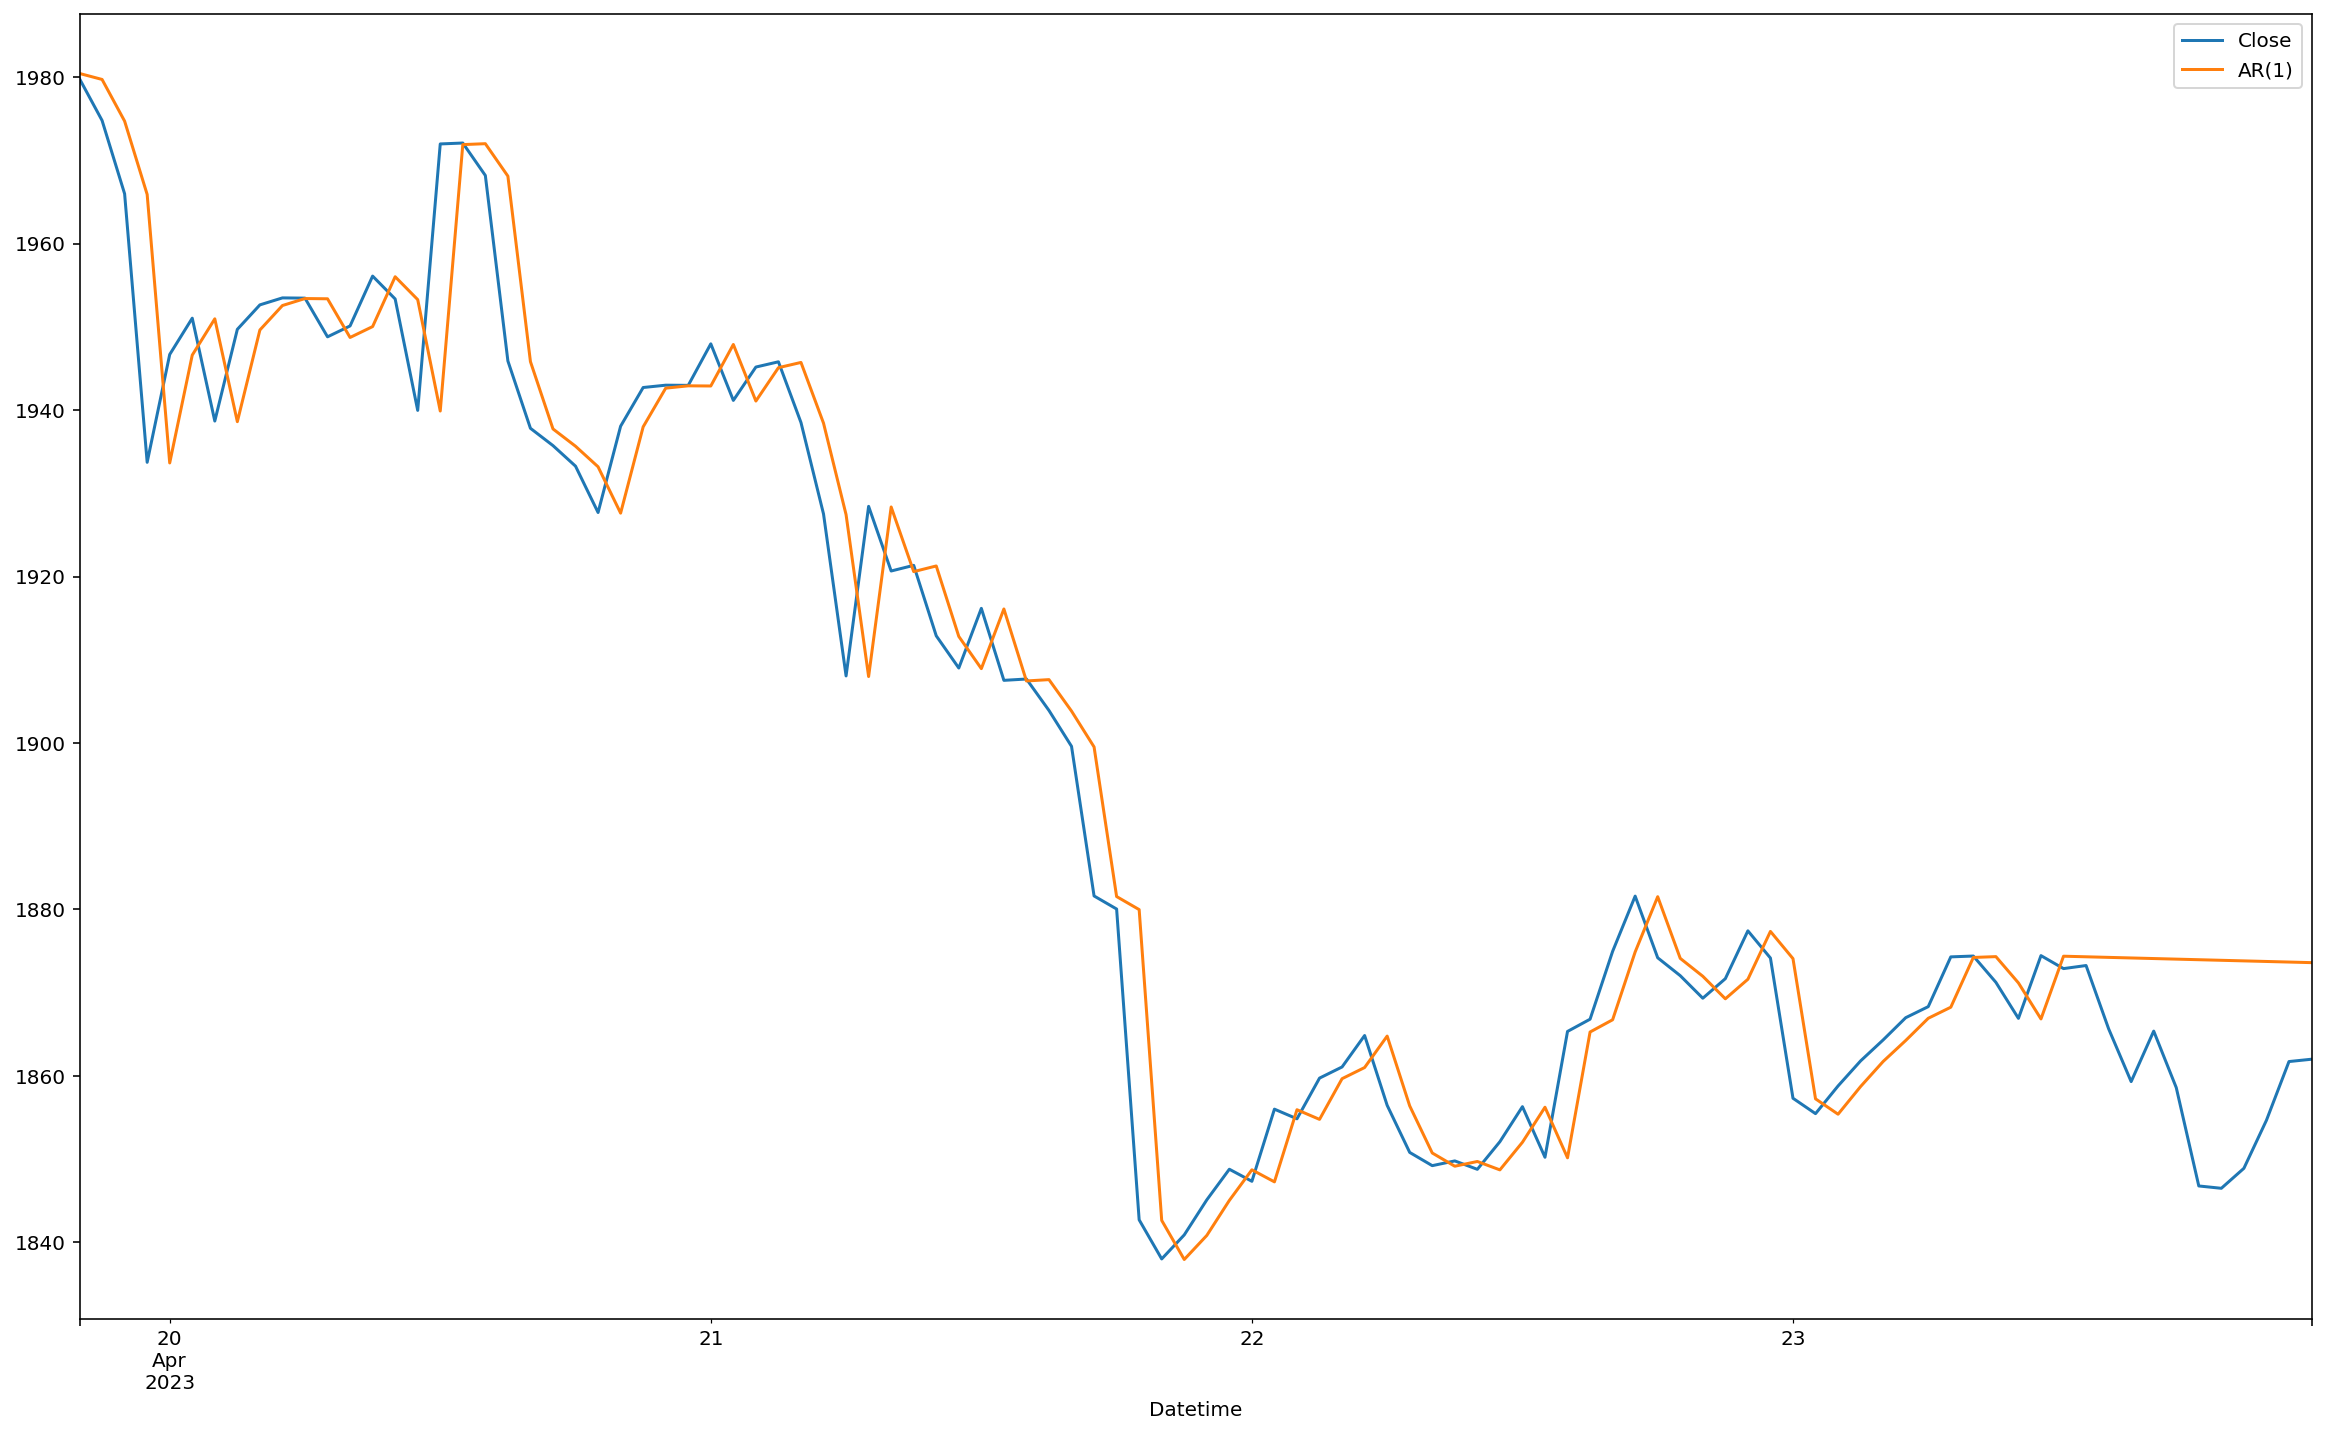

In [141]:
df[['Close', 'AR(1)']].iloc[-100:].plot(figsize=(20,12));

In [142]:
# Explore prediction result
type(prediction_result)

statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper

In [143]:
df

,Open,High,Low,Close,Volume,Trades,First_Diff,Log_Close,AR(1)
Datetime,,,,,,,,,
2017-09-01 00:00:00,384.79,388.74,384.79,388.74,162.97779,131,NaN,5.962911,1129.635138
2017-09-01 01:00:00,388.69,394.06,387.53,391.37,248.72949,262,2.63,5.969653,388.809898
2017-09-01 02:00:00,392.88,394.39,389.46,390.88,198.82856,225,-0.49,5.968401,391.439650
2017-09-01 03:00:00,391.70,393.13,390.86,390.86,141.56114,138,-0.02,5.968349,390.949696
2017-09-01 04:00:00,392.65,394.27,387.64,390.33,135.65894,128,-0.53,5.966993,390.929698
...,...,...,...,...,...,...,...,...,...
2023-04-23 19:00:00,1846.76,1852.35,1844.92,1846.49,16550.18290,21648,-0.28,7.521042,1873.888042
2023-04-23 20:00:00,1846.49,1852.30,1838.03,1848.89,13113.47550,19445,2.40,7.522341,1873.817828
2023-04-23 21:00:00,1848.88,1859.32,1847.59,1854.66,7855.61330,13824,5.77,7.525457,1873.747619


In [144]:
# Confidence interval
prediction_result.conf_int()

,lower Close,upper Close
49325,1843.351441,1905.408023
49326,1830.430910,1918.188031
49327,1820.501709,1927.976723
49328,1812.121167,1936.216770
49329,1804.730448,1943.467006
49330,1798.042934,1950.014050
49331,1791.888351,1956.028176
49332,1786.155753,1961.620332
49333,1780.768071,1966.867584
49334,1775.669189,1971.826049


In [146]:
def plot_fit_and_forecast(arima_result, col='Close', show_last_periods=0):
    """
    Функция для визуализации результатов ARIMA на тренировочной и тестовой выборке.

    :param arima_result: Объект после применения функции fit
    :param col: Имя столбца датафрейма по которому шло обучение 
    :param show_last_periods: сколько последних периодов показывать, если 0, то визуализировать весь датафрейм
    """
        
    df_for_plot = df.copy()
    df_for_plot.loc[train_idx, 'train'] = arima_result.predict(start=train.index[0], end=train.index[-1])
    prediction_result = arima_result.get_forecast(N_test)
    conf_int = prediction_result.conf_int()
    lowwer, upper = conf_int[f'lower {col}'], conf_int[f'upper {col}']
    forecast = prediction_result.predicted_mean.to_numpy()
    df_for_plot.loc[test_idx, 'forecast'] = forecast
    
    if show_last_periods > 0:
        df_for_plot = df_for_plot.iloc[-show_last_periods:]
        
    fig, ax = plt.subplots(figsize=(20, 12))
    ax.plot(df_for_plot[col], label=col)
    
    ax.plot(df_for_plot['train'], color='green', label='Train')
    ax.plot(df_for_plot['forecast'], label='Forecast')
    ax.fill_between(test.index, lowwer, upper, color='Red', alpha=0.2)
    ax.legend()

c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


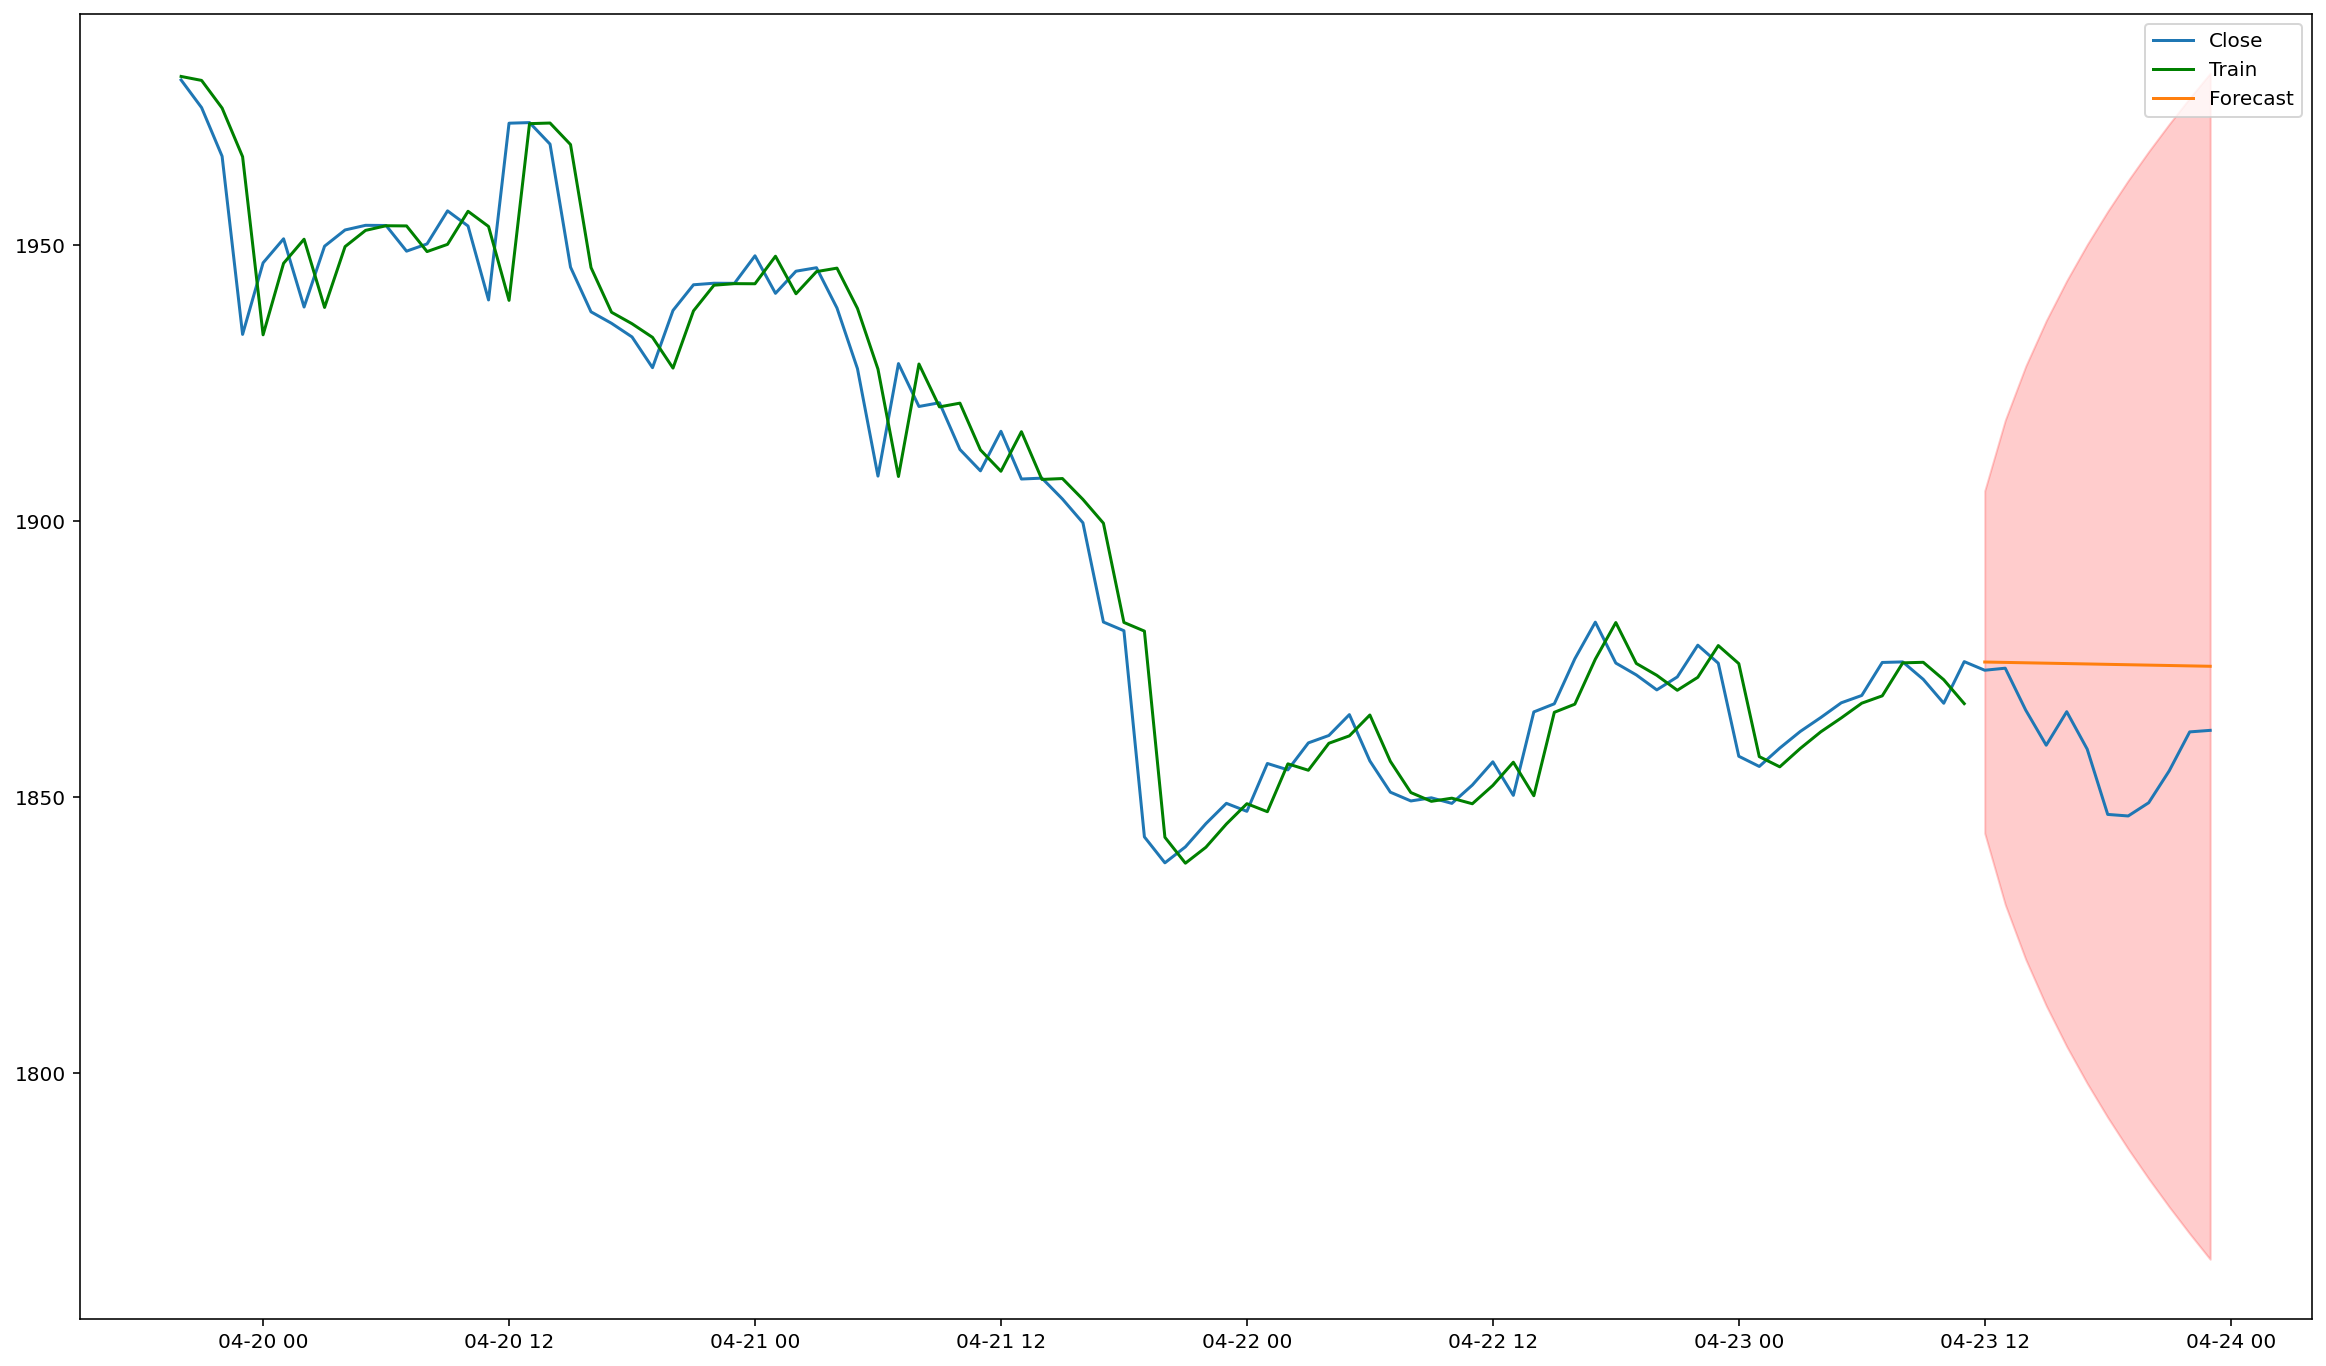

In [147]:
plot_fit_and_forecast(arima_result, show_last_periods=100)

# Добавим больше inputs in AR

In [152]:
# AR(10)
arima = ARIMA(train['Close'], order=(120, 0, 0))
arima_result = arima.fit()
plot_fit_and_forecast(arima_result, show_last_periods=100)


c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


KeyboardInterrupt: 

С 10 признаками в последовательности исторических данных модель выглядит более качественно

c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


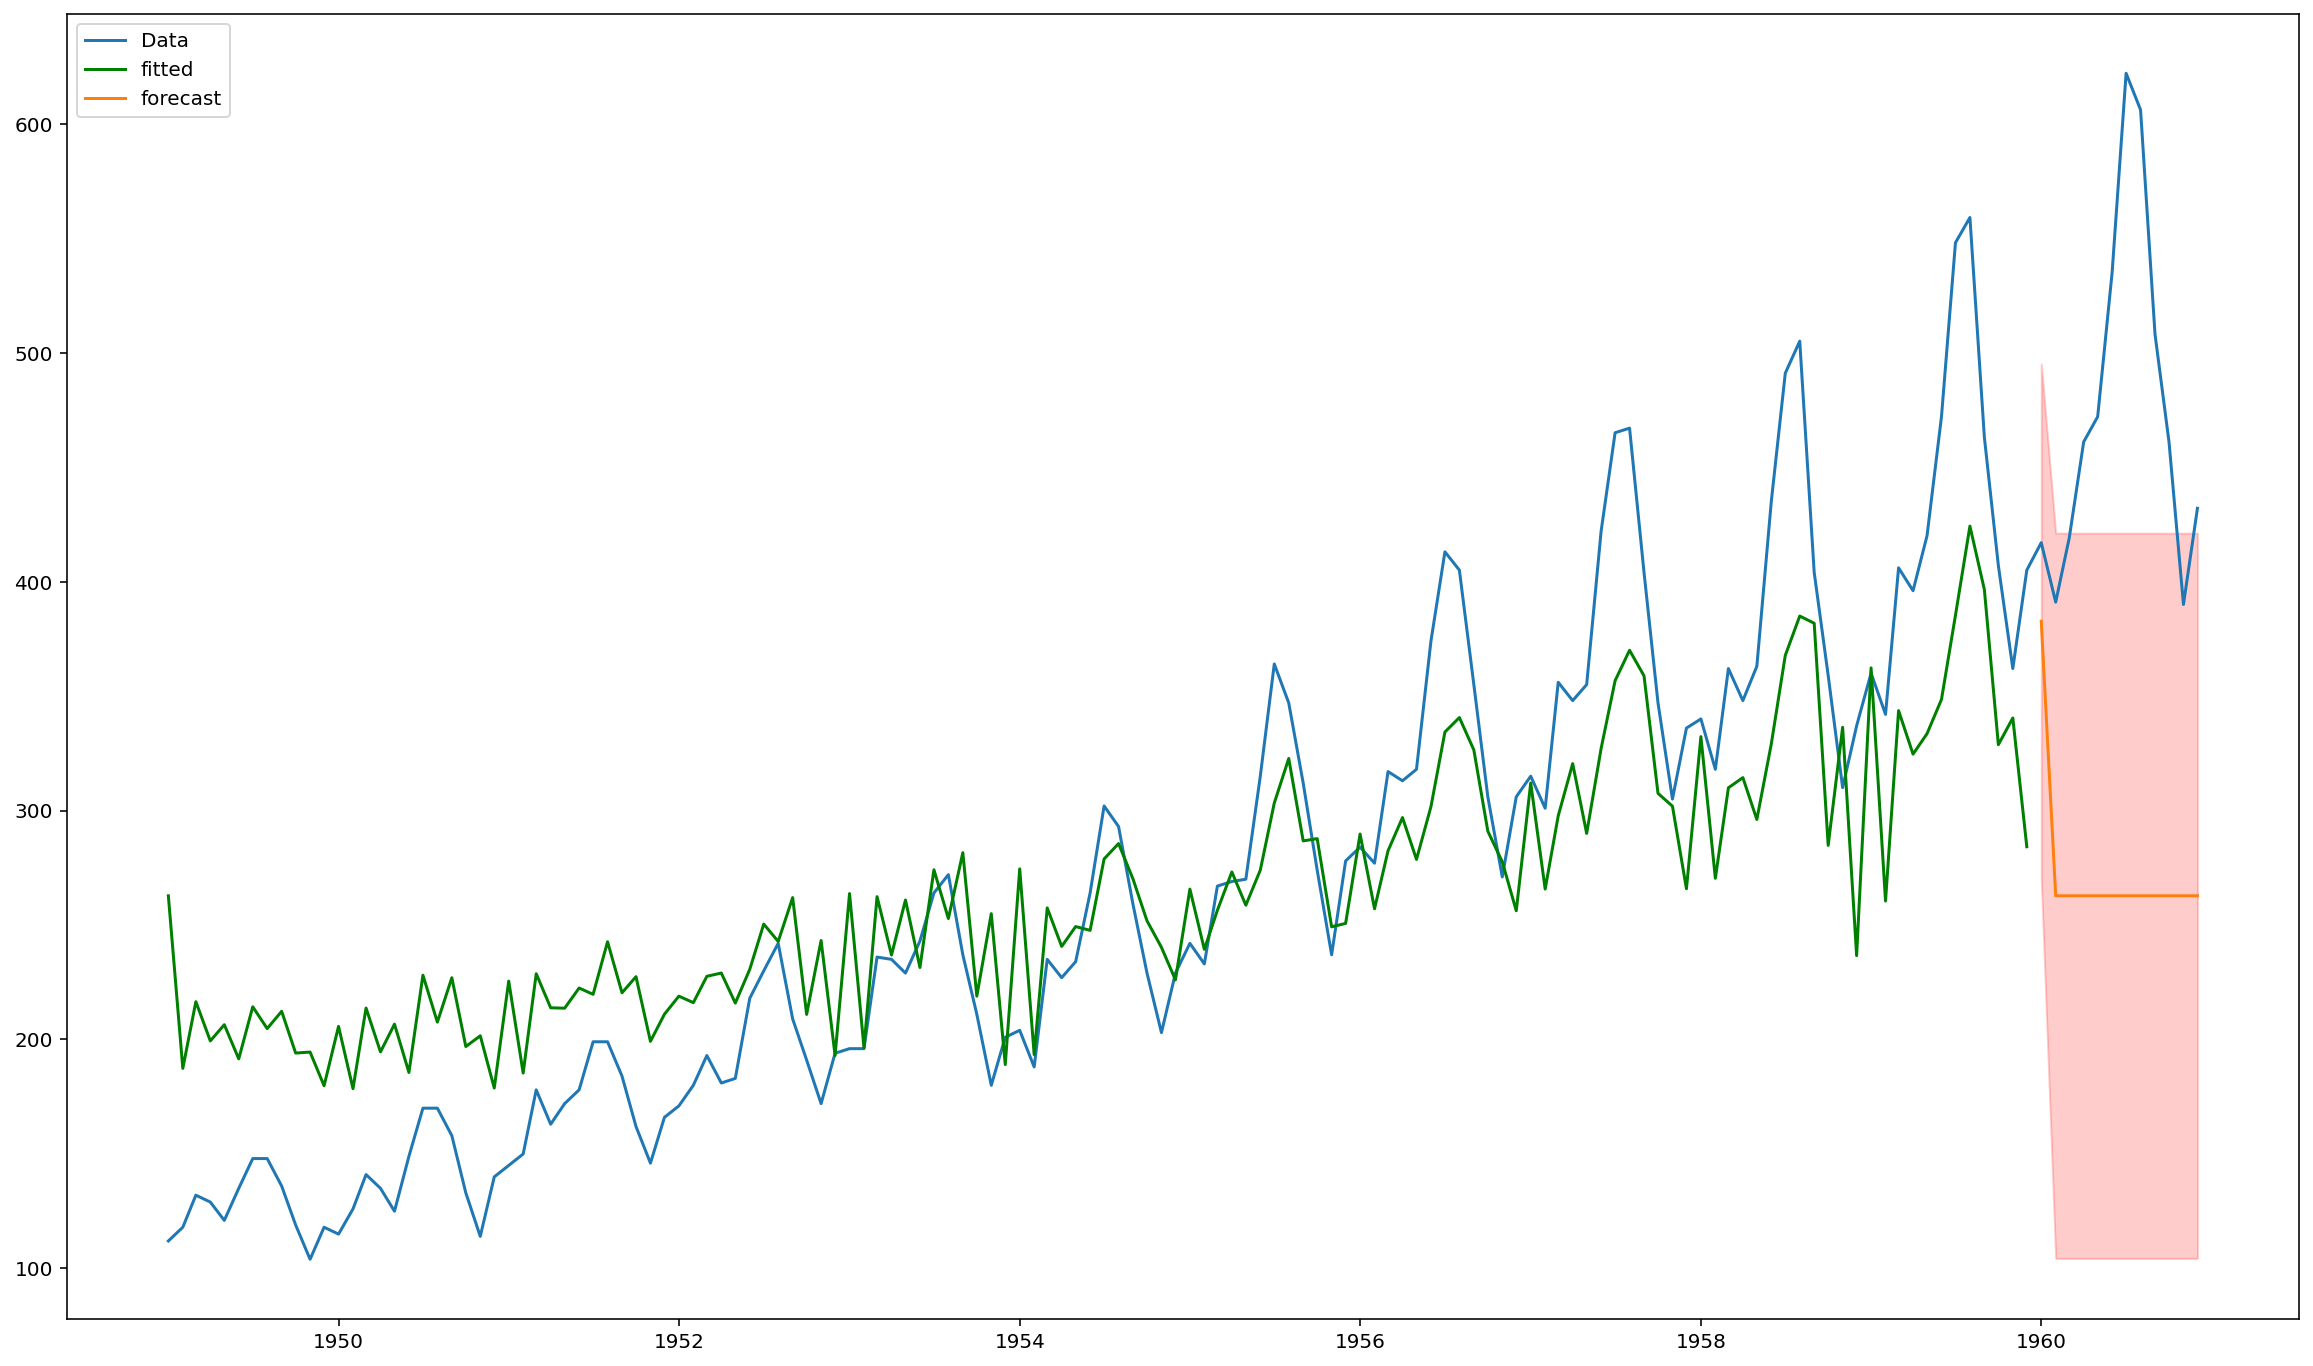

In [102]:
# MA(1)
arima = ARIMA(train['Close'], order=(0, 0, 1))
arima_result = arima.fit()
plot_fit_and_forecast(arima_result, show_last_periods=100)

### Пробуем перейти к логарифмической первой разнице
Фактически Log Return.

Тут просто визуализация, переход будет производиться в самой моделе ARIMA. Через задание параметра d=1.

In [103]:
df['Log_First_Diff'] = df['Log_Close'].diff()

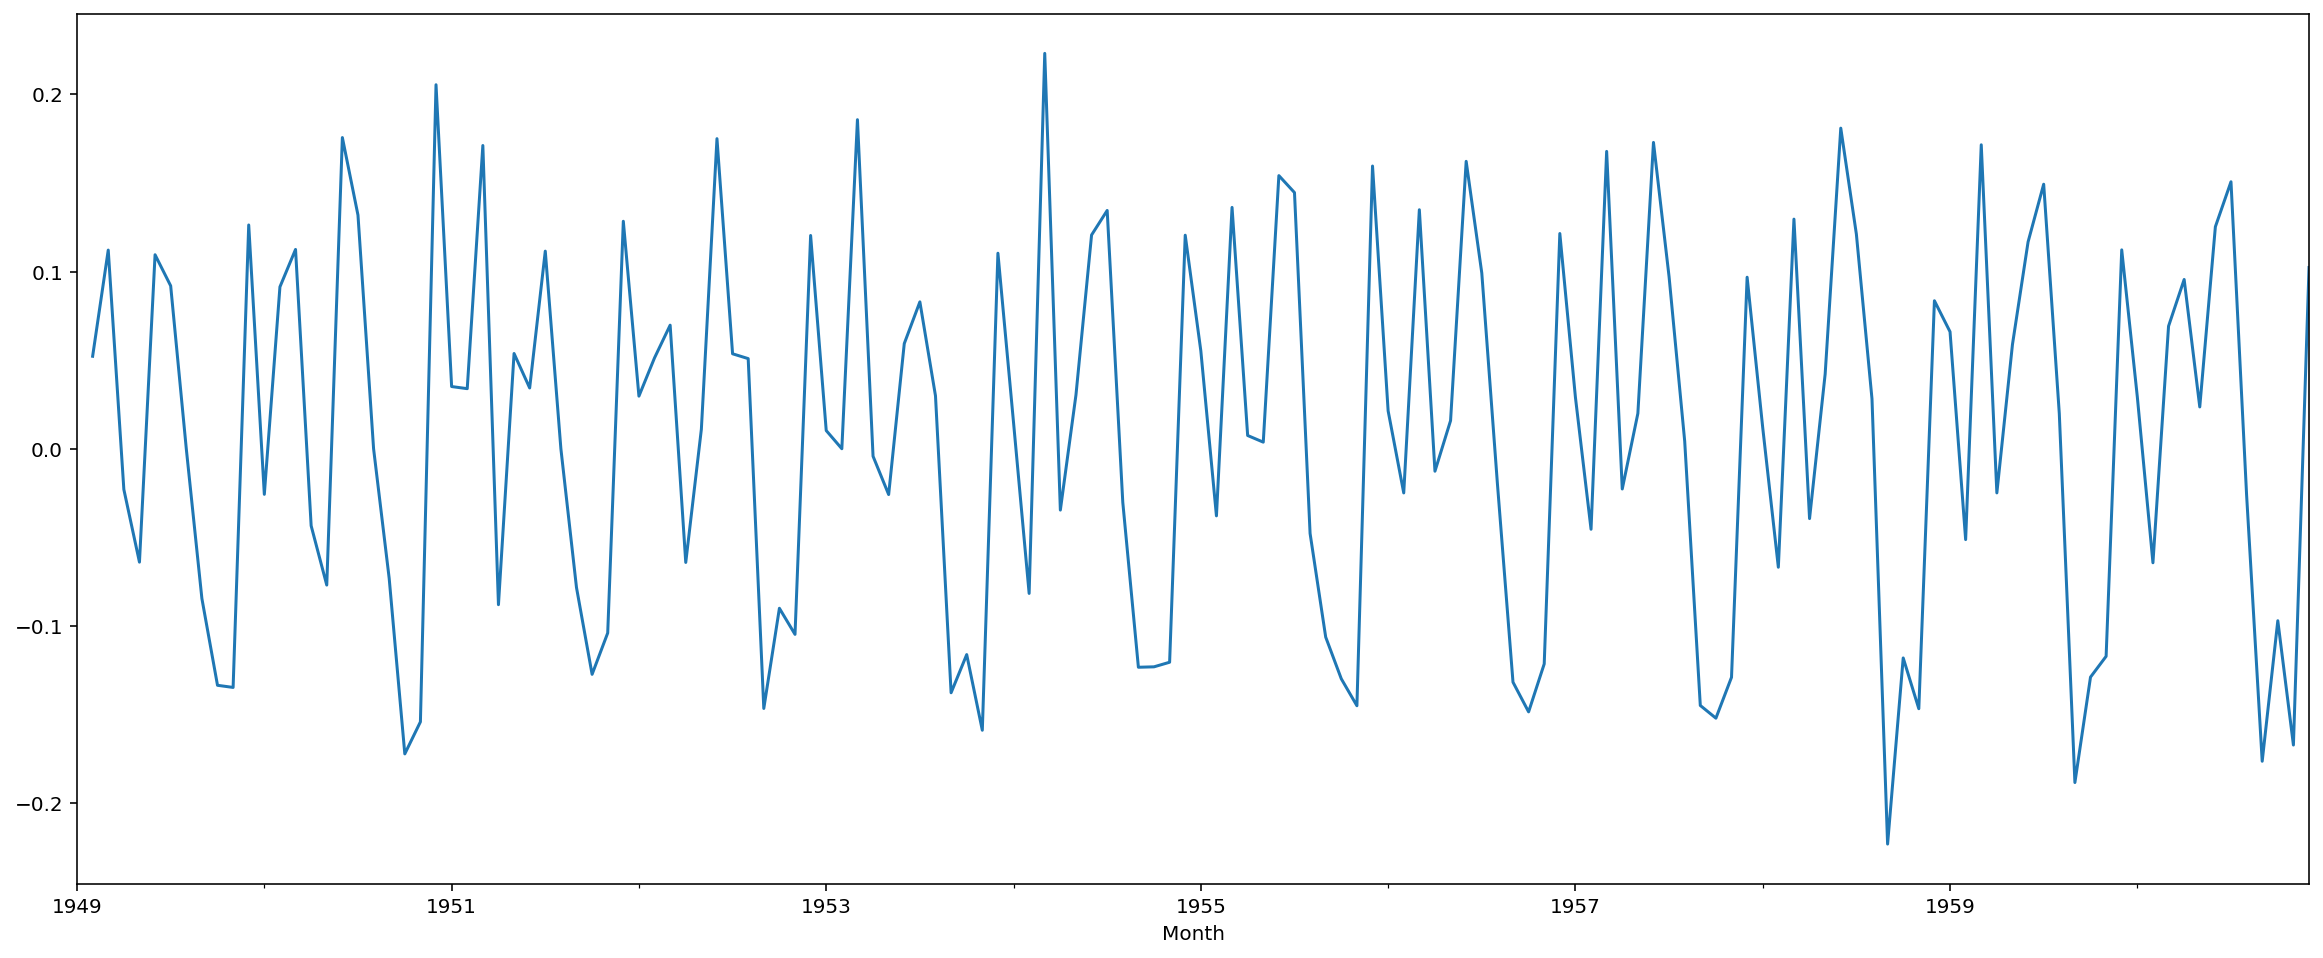

In [104]:
df['Log_First_Diff'].plot(figsize=(20, 8));

In [105]:
def plot_fit_and_forecast_int(arima_result, d, col='Close', show_last_periods=0):  
    """
    Функция для визуализации результатов ARIMA на тренировочной и тестовой выборке.

    :param arima_result: Объект после применения функции fit
    :param d: Значение дифференциации I(d) 
    :param col: Имя столбца датафрейма по которому шло обучение 
    :param show_last_periods: сколько последних периодов показывать, если 0, то визуализировать весь датафрейм
    """
        
    df_for_plot = df.copy()
    df_for_plot = df_for_plot.iloc[d:]
    
    df_for_plot.loc[train_idx, 'train'] = arima_result.predict(start=train.index[d], end=train.index[-1])
    prediction_result = arima_result.get_forecast(N_test)
    conf_int = prediction_result.conf_int()
    lowwer, upper = conf_int[f'lower {col}'], conf_int[f'upper {col}']
    forecast = prediction_result.predicted_mean.to_numpy()
    df_for_plot.loc[test_idx, 'forecast'] = forecast
    
    if show_last_periods > 0:
        df_for_plot = df_for_plot.iloc[-show_last_periods:]
        
    fig, ax = plt.subplots(figsize=(20, 12))
    ax.plot(df_for_plot[col], label=col)
    
    ax.plot(df_for_plot['train'], color='green', label='Train')
    ax.plot(df_for_plot['forecast'], label='Forecast')
    ax.fill_between(test.index, lowwer, upper, color='Red', alpha=0.2)
    ax.legend()

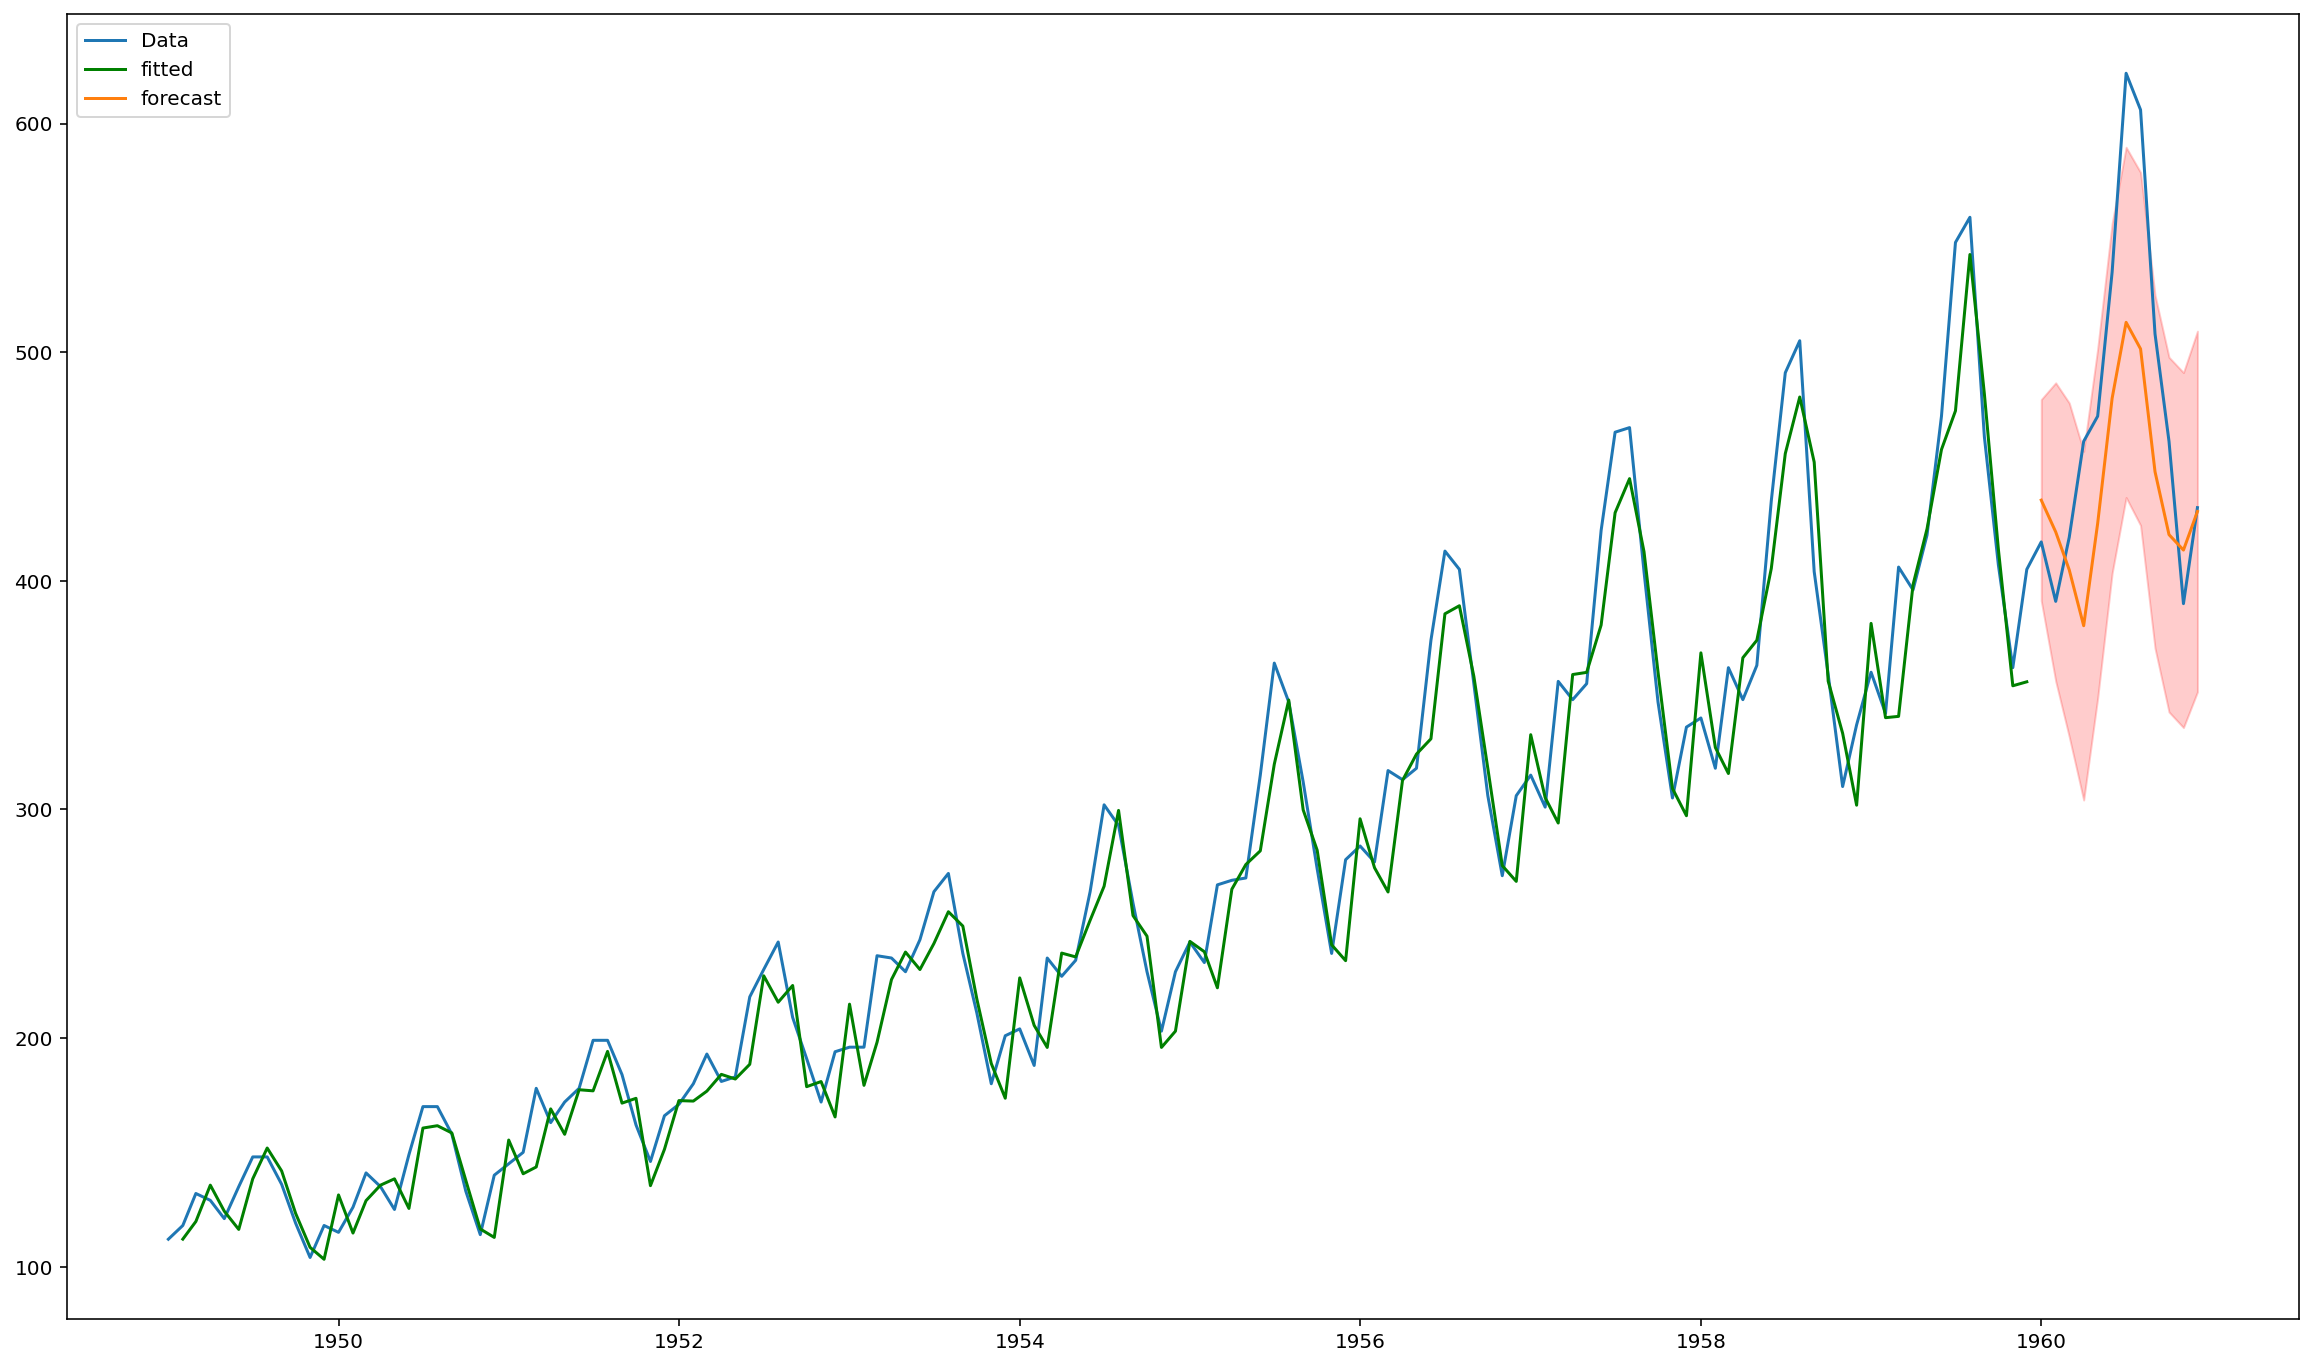

In [106]:
plot_fit_and_forecast_int(arima_result_811, 1)

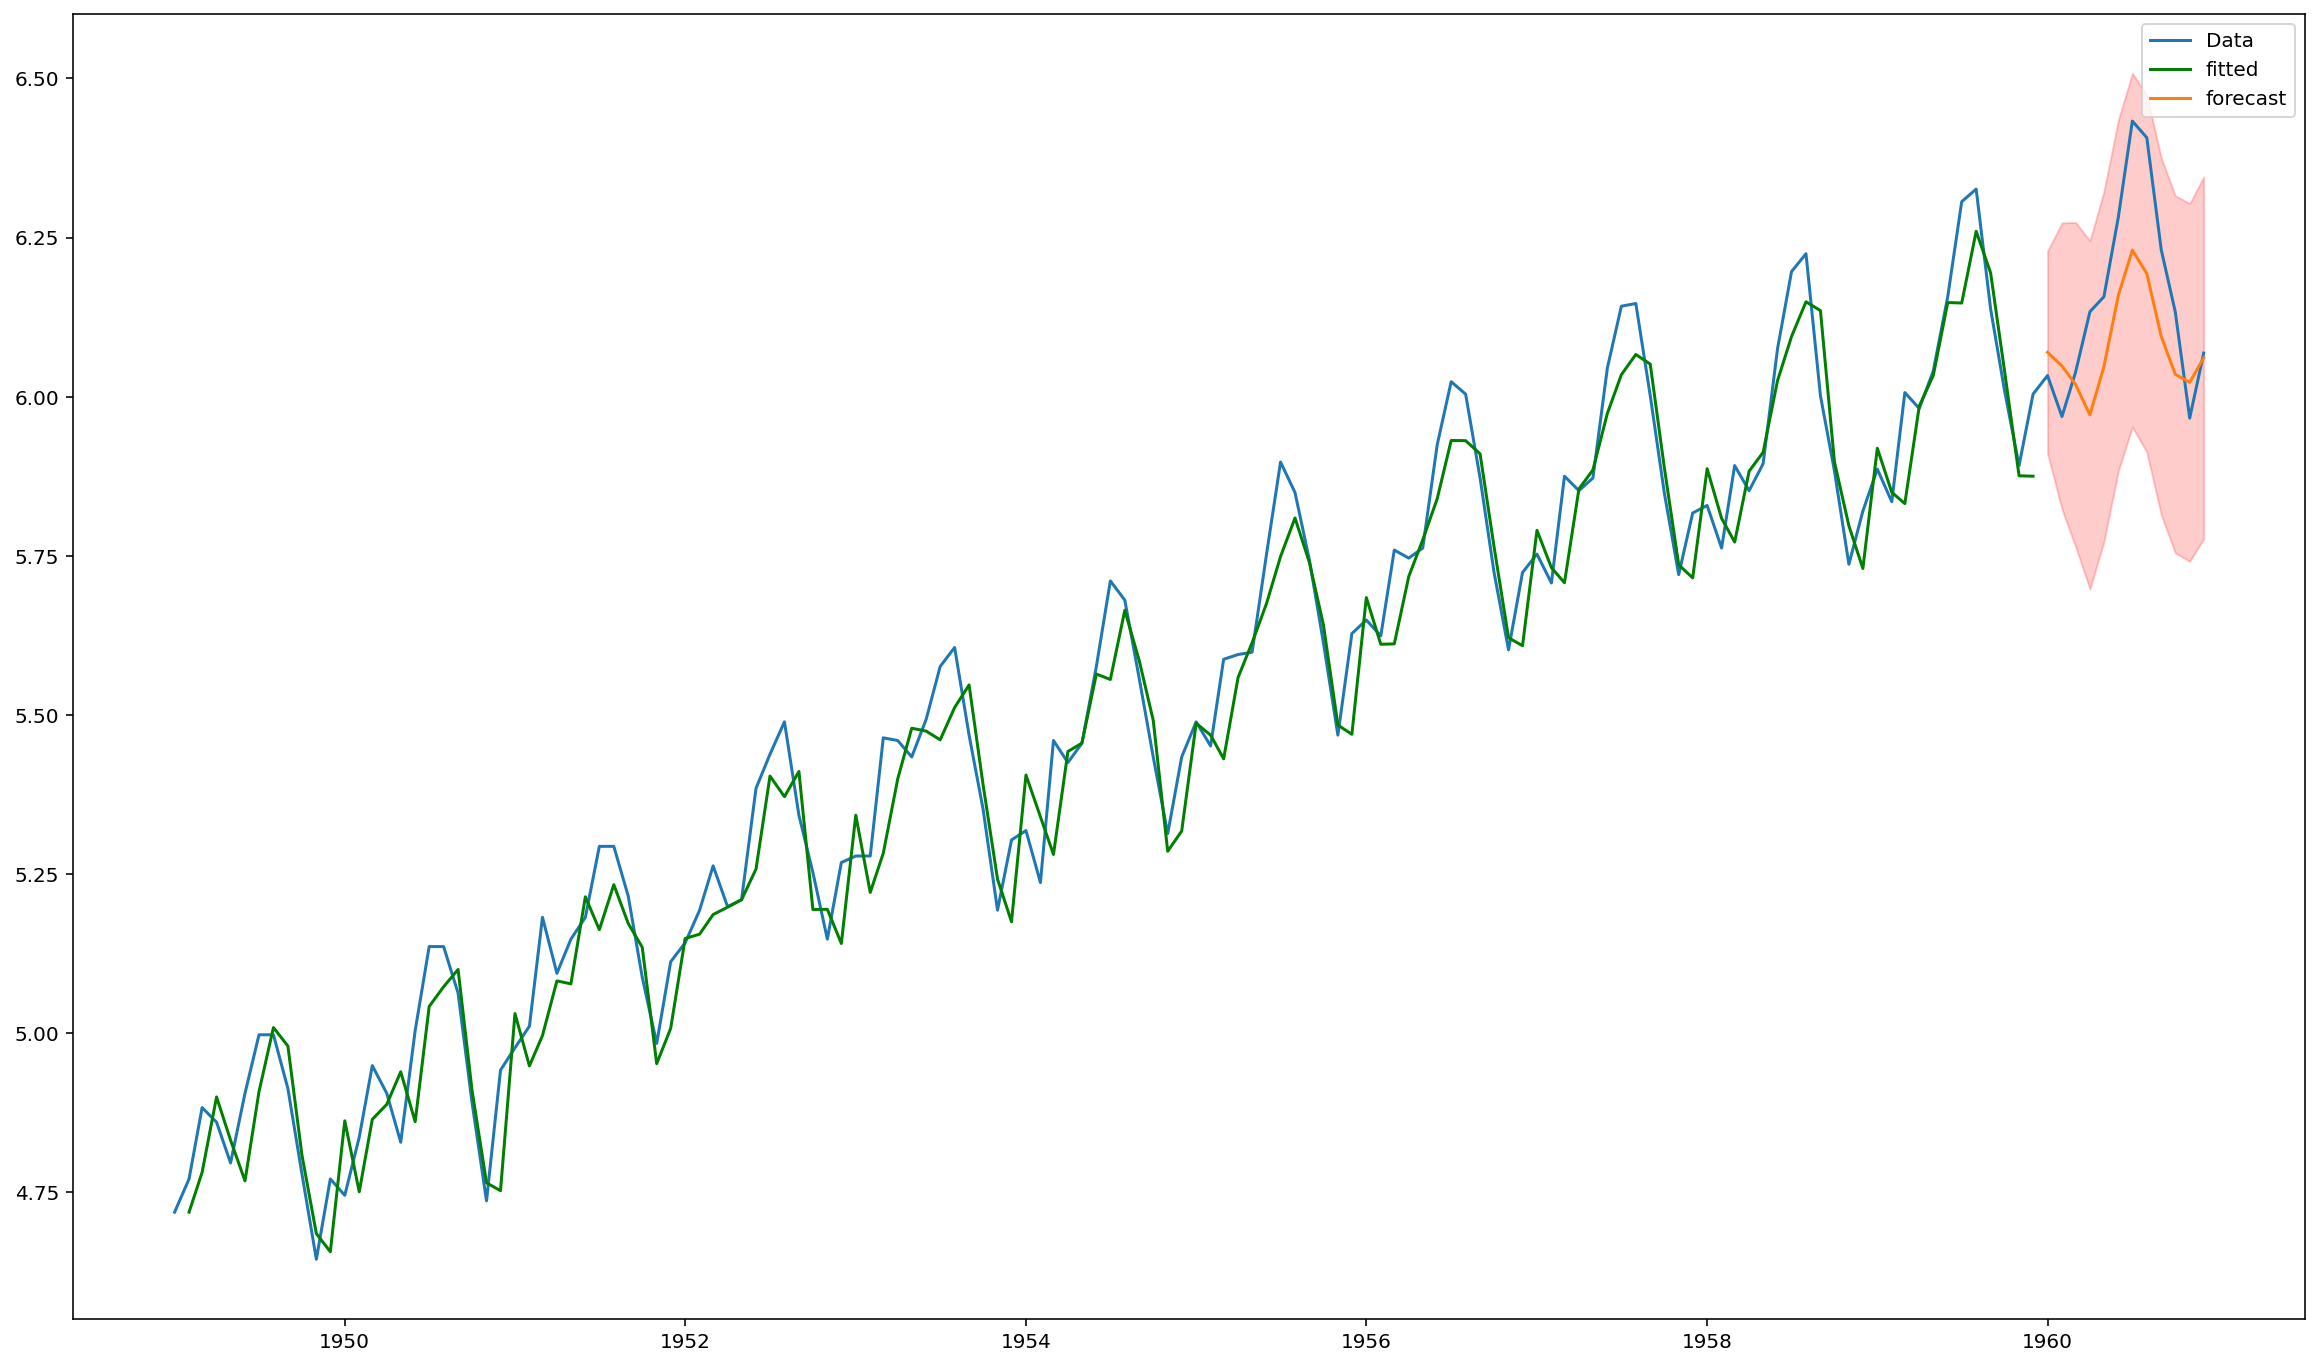

In [107]:
arima = ARIMA(train['Log_Passengers'], order=(8, 1, 1))
arima_result_811_log = arima.fit()
plot_fit_and_forecast_int(arima_result_811_log, 1, 'Log_Passengers')

c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


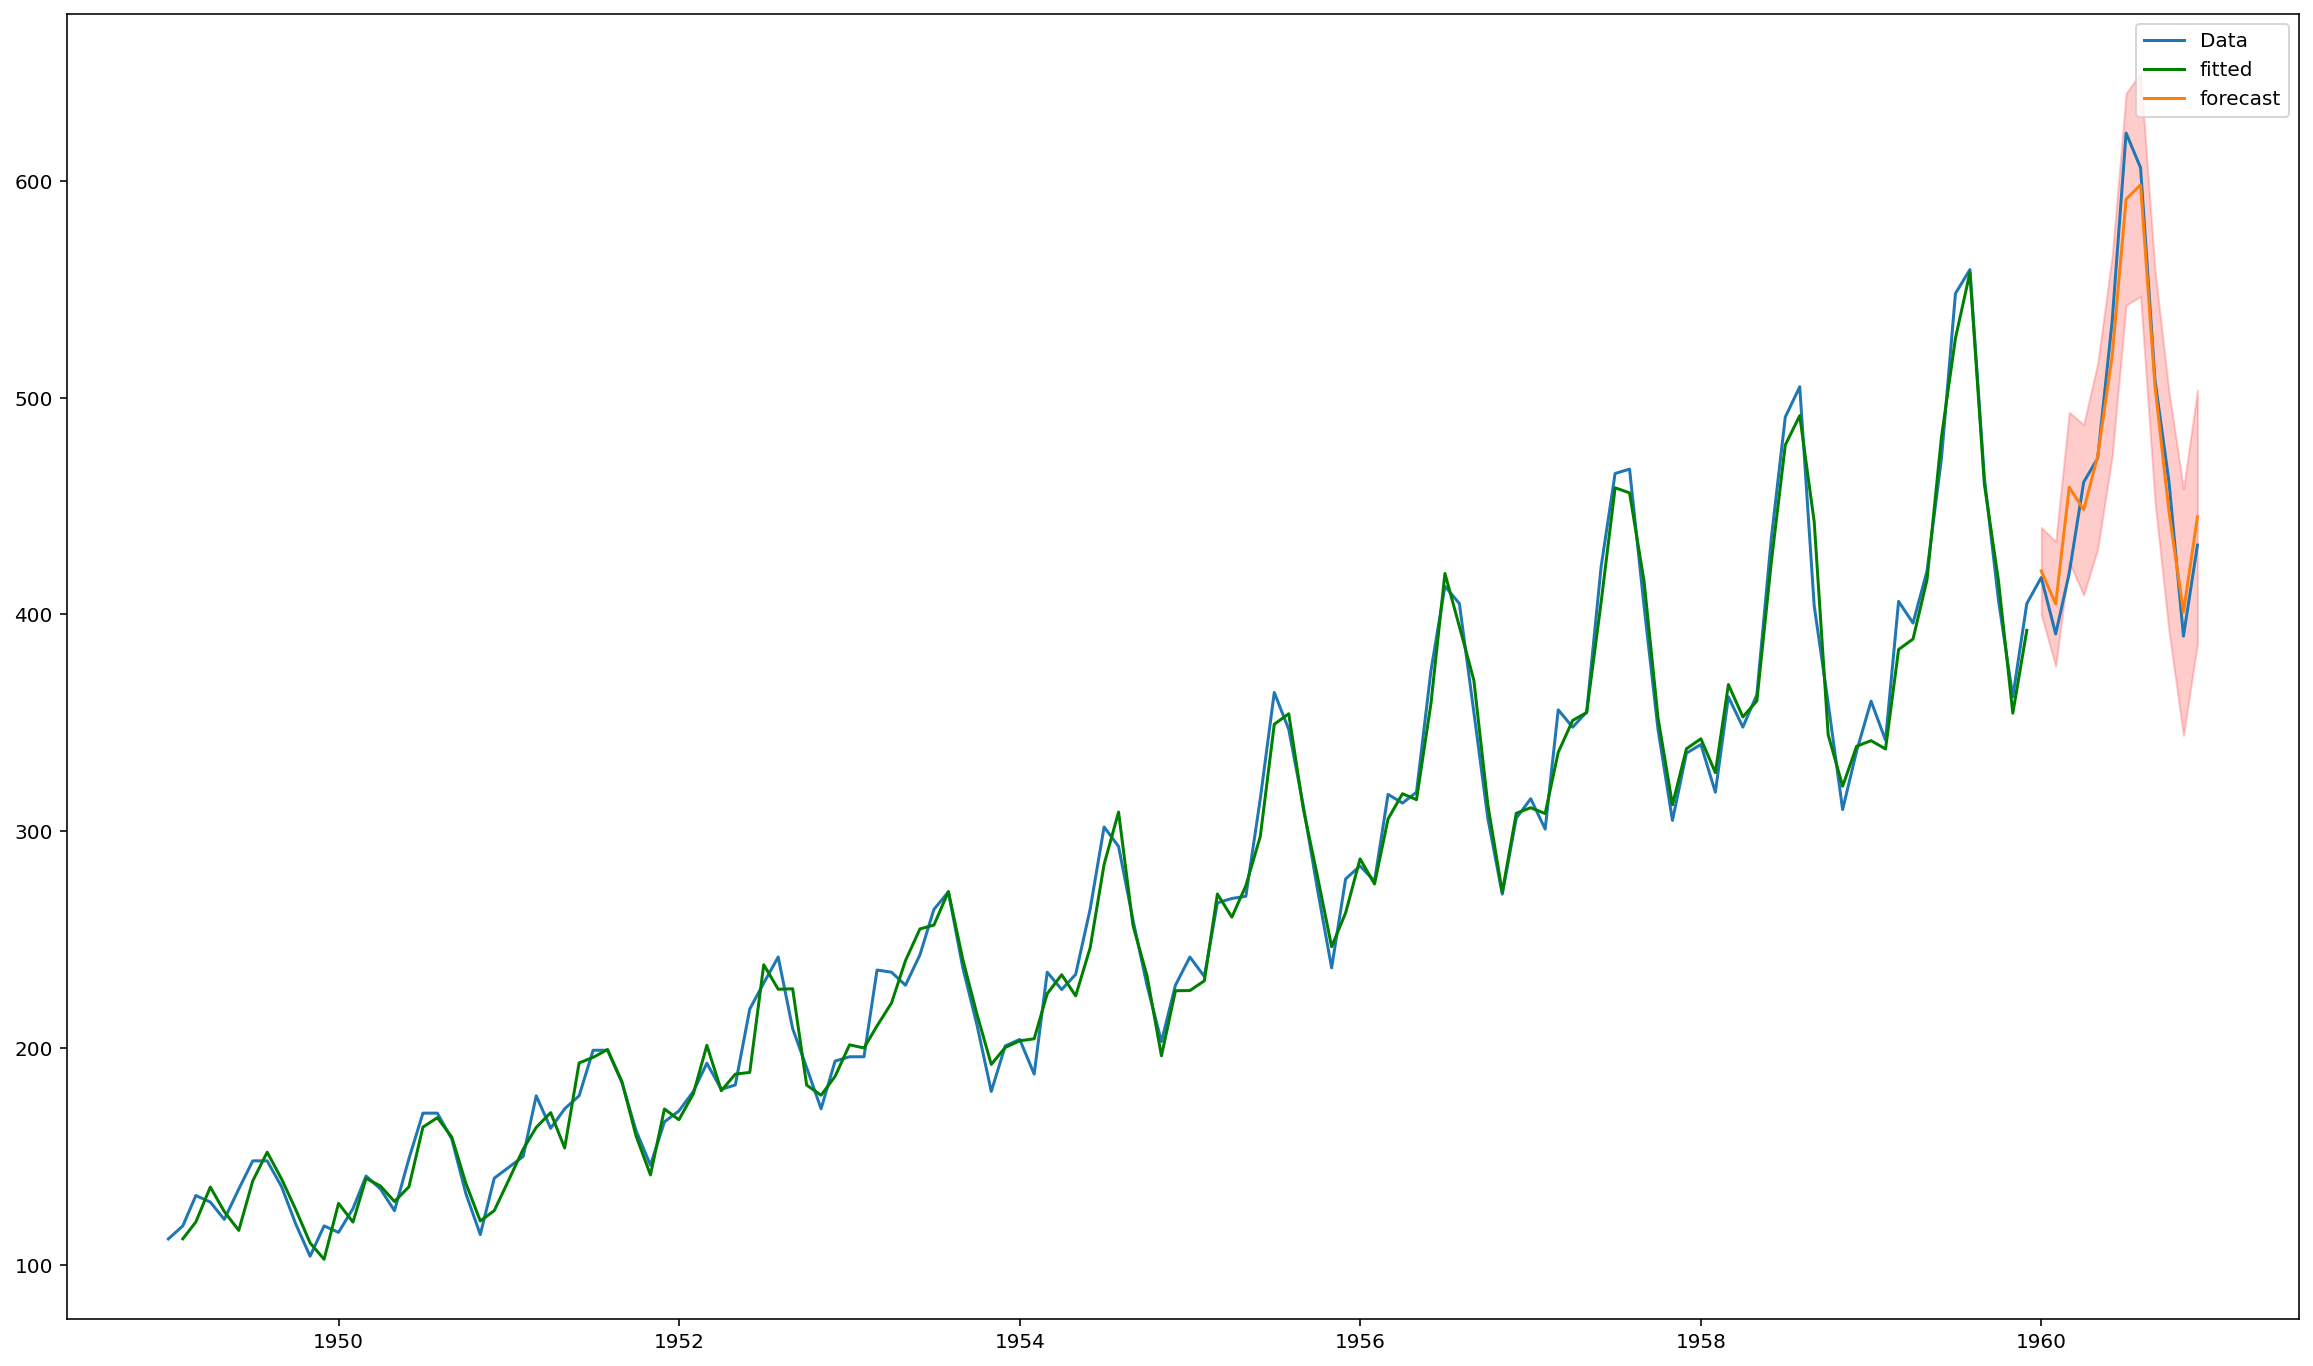

In [108]:
arima = ARIMA(train['Passengers'], order=(12, 1, 0))
arima_result_1210 = arima.fit()
plot_fit_and_forecast_int(arima_result_1210, 1, 'Passengers')

c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


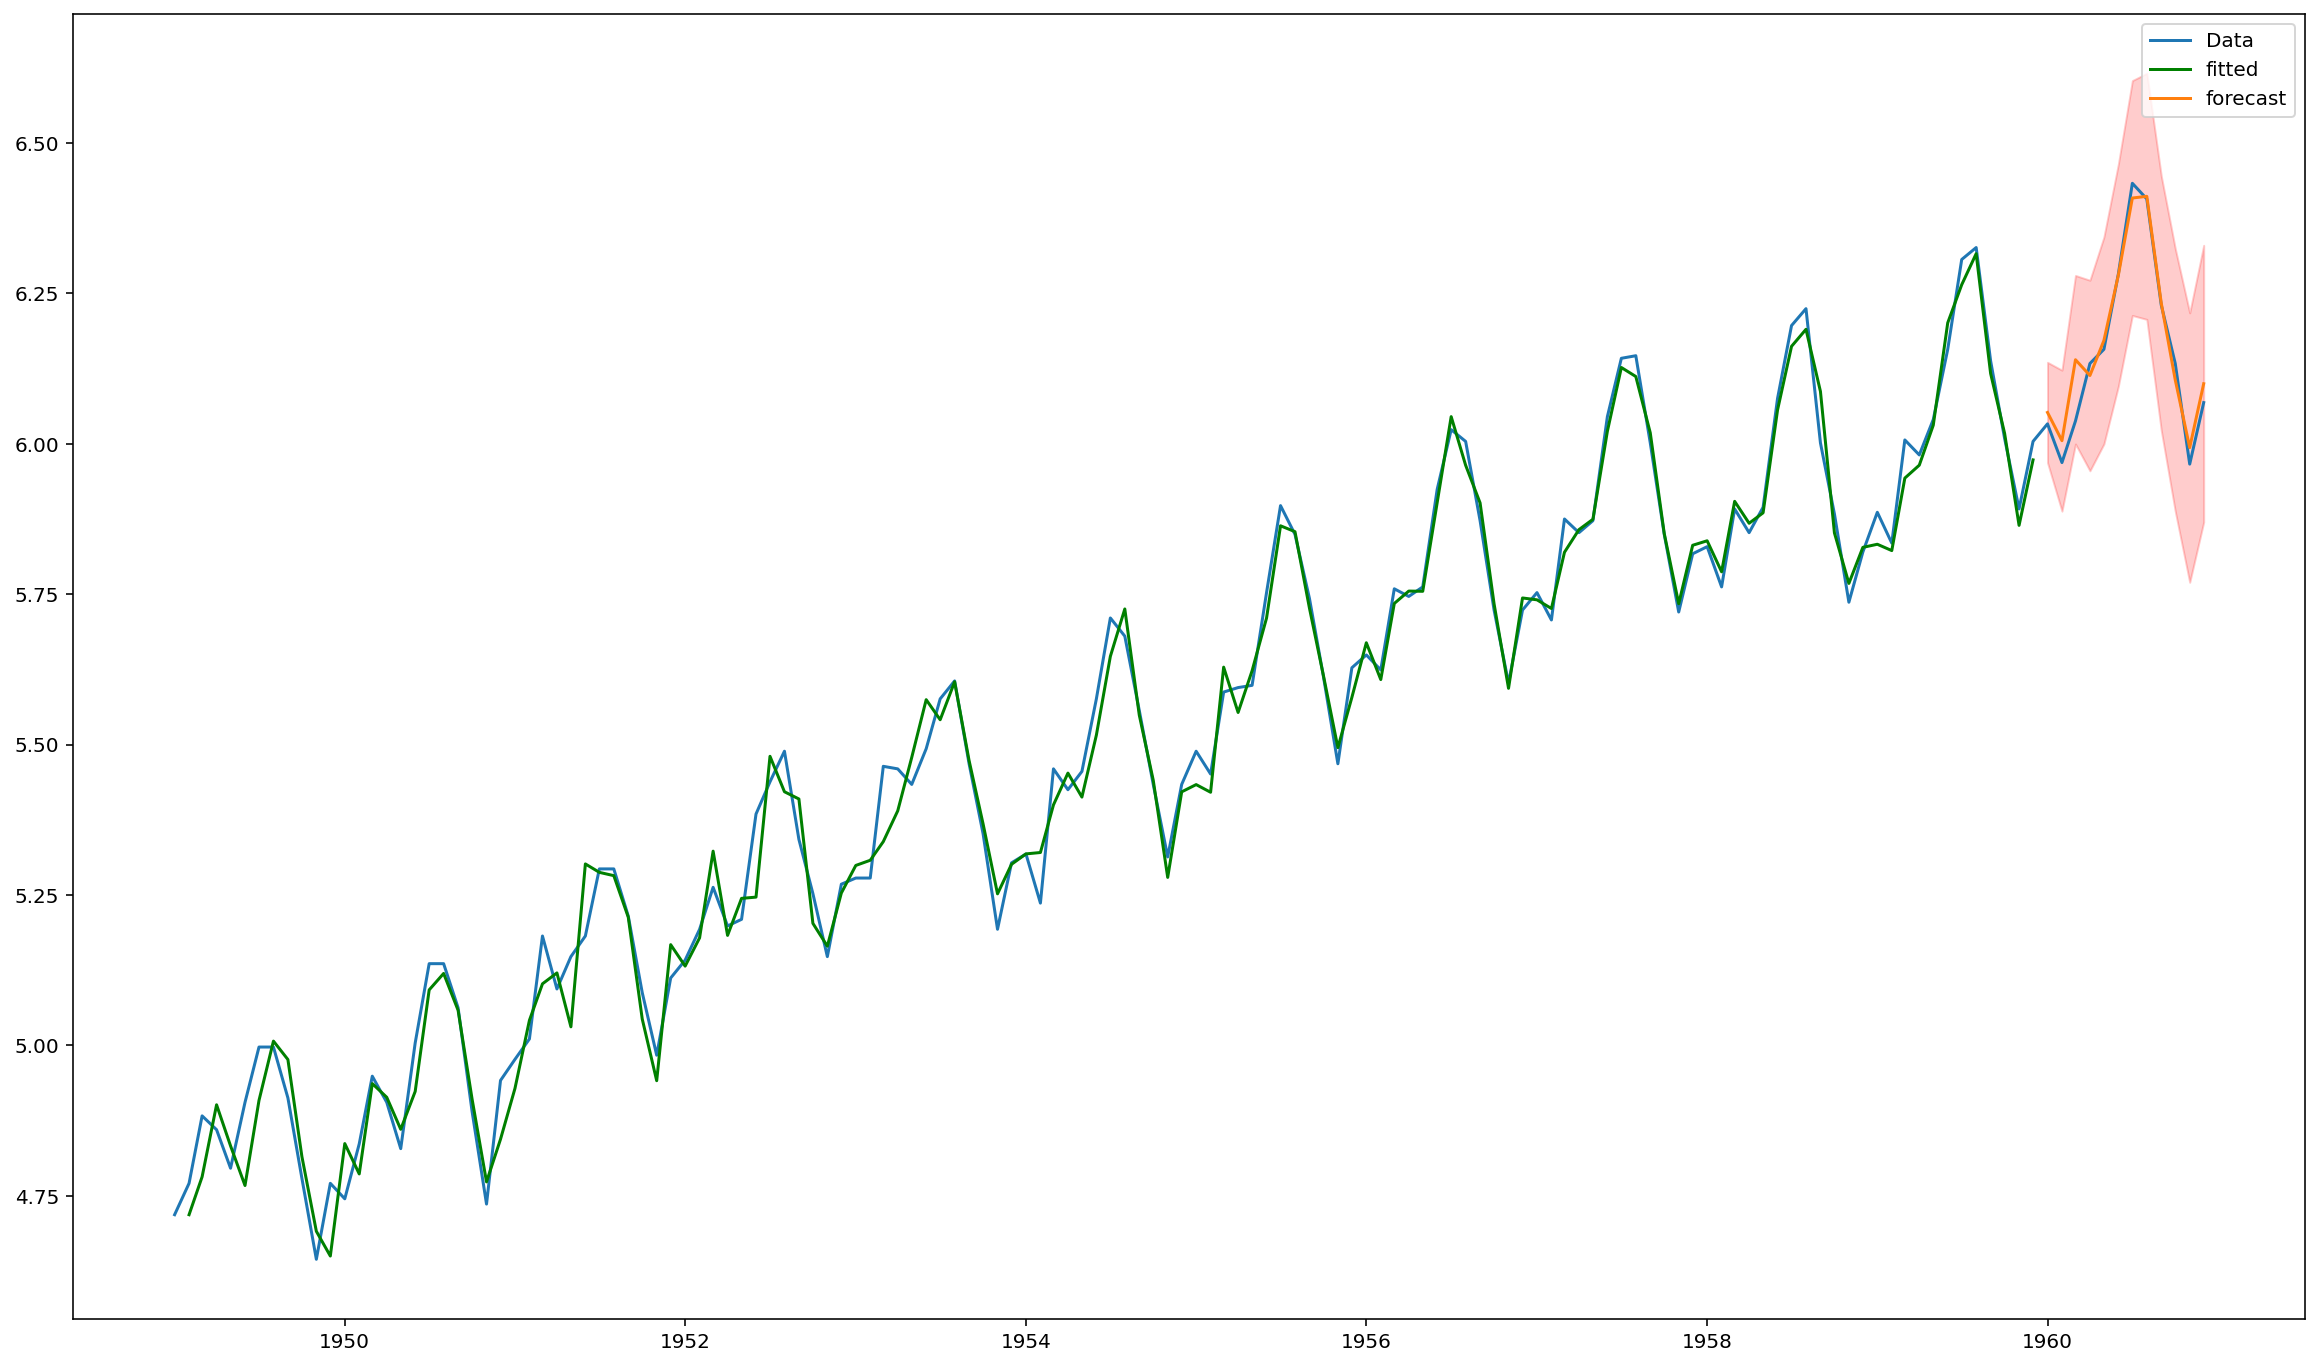

In [109]:
arima = ARIMA(train['Log_Passengers'], order=(12, 1, 0))
arima_result_1210_log = arima.fit()
plot_fit_and_forecast_int(arima_result_1210_log, 1, 'Log_Passengers')

- Путем проб и ошибок приходим к периоду 12, в целом цилк годовой, это логично.
- Пробоуем обычные значения подавать и логарифмированные.
- Обе модели с d=1. Т.е. для модели на логарифмических данных внутри ARIMA полдучается что используется Log_Return

### Что бы понять какая модель лучше, посчитаем метрику RMSE
можно было использовать и стандартные функции, но тут вот все инкапсулировали

ведь для лог значений нужно будет делать обратное преобразования для корректного сравнения

In [110]:
def rmse(arima_result, is_log):
    forecast = arima_result.forecast(N_test)
    
    if is_log:
        forecast = np.exp(forecast)
    
    y_true = test['Passengers']
    y_pred = forecast
    
    return  np.sqrt(np.mean((y_true - y_pred)**2))

In [111]:
print(f'ARIMA 8,1,1 RMSE: {rmse(arima_result_811, False):.2f}')
print(f'ARIMA 8,1,1 Log RMSE: {rmse(arima_result_811_log, False):.2f}')
print(f'ARIMA 12,1,0 RMSE: {rmse(arima_result_1210, False):.2f}')
print(f'ARIMA 12,1,0 Log RMSE: {rmse(arima_result_1210_log, True):.2f}')

ARIMA 8,1,1 RMSE: 59.06
ARIMA 8,1,1 Log RMSE: 475.93
ARIMA 12,1,0 RMSE: 17.49
ARIMA 12,1,0 Log RMSE: 16.13


Модель с логарифмическим признаком показывает чуть меньшую ошибку на тестовой выборке

c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA Log RMSE: 15.13


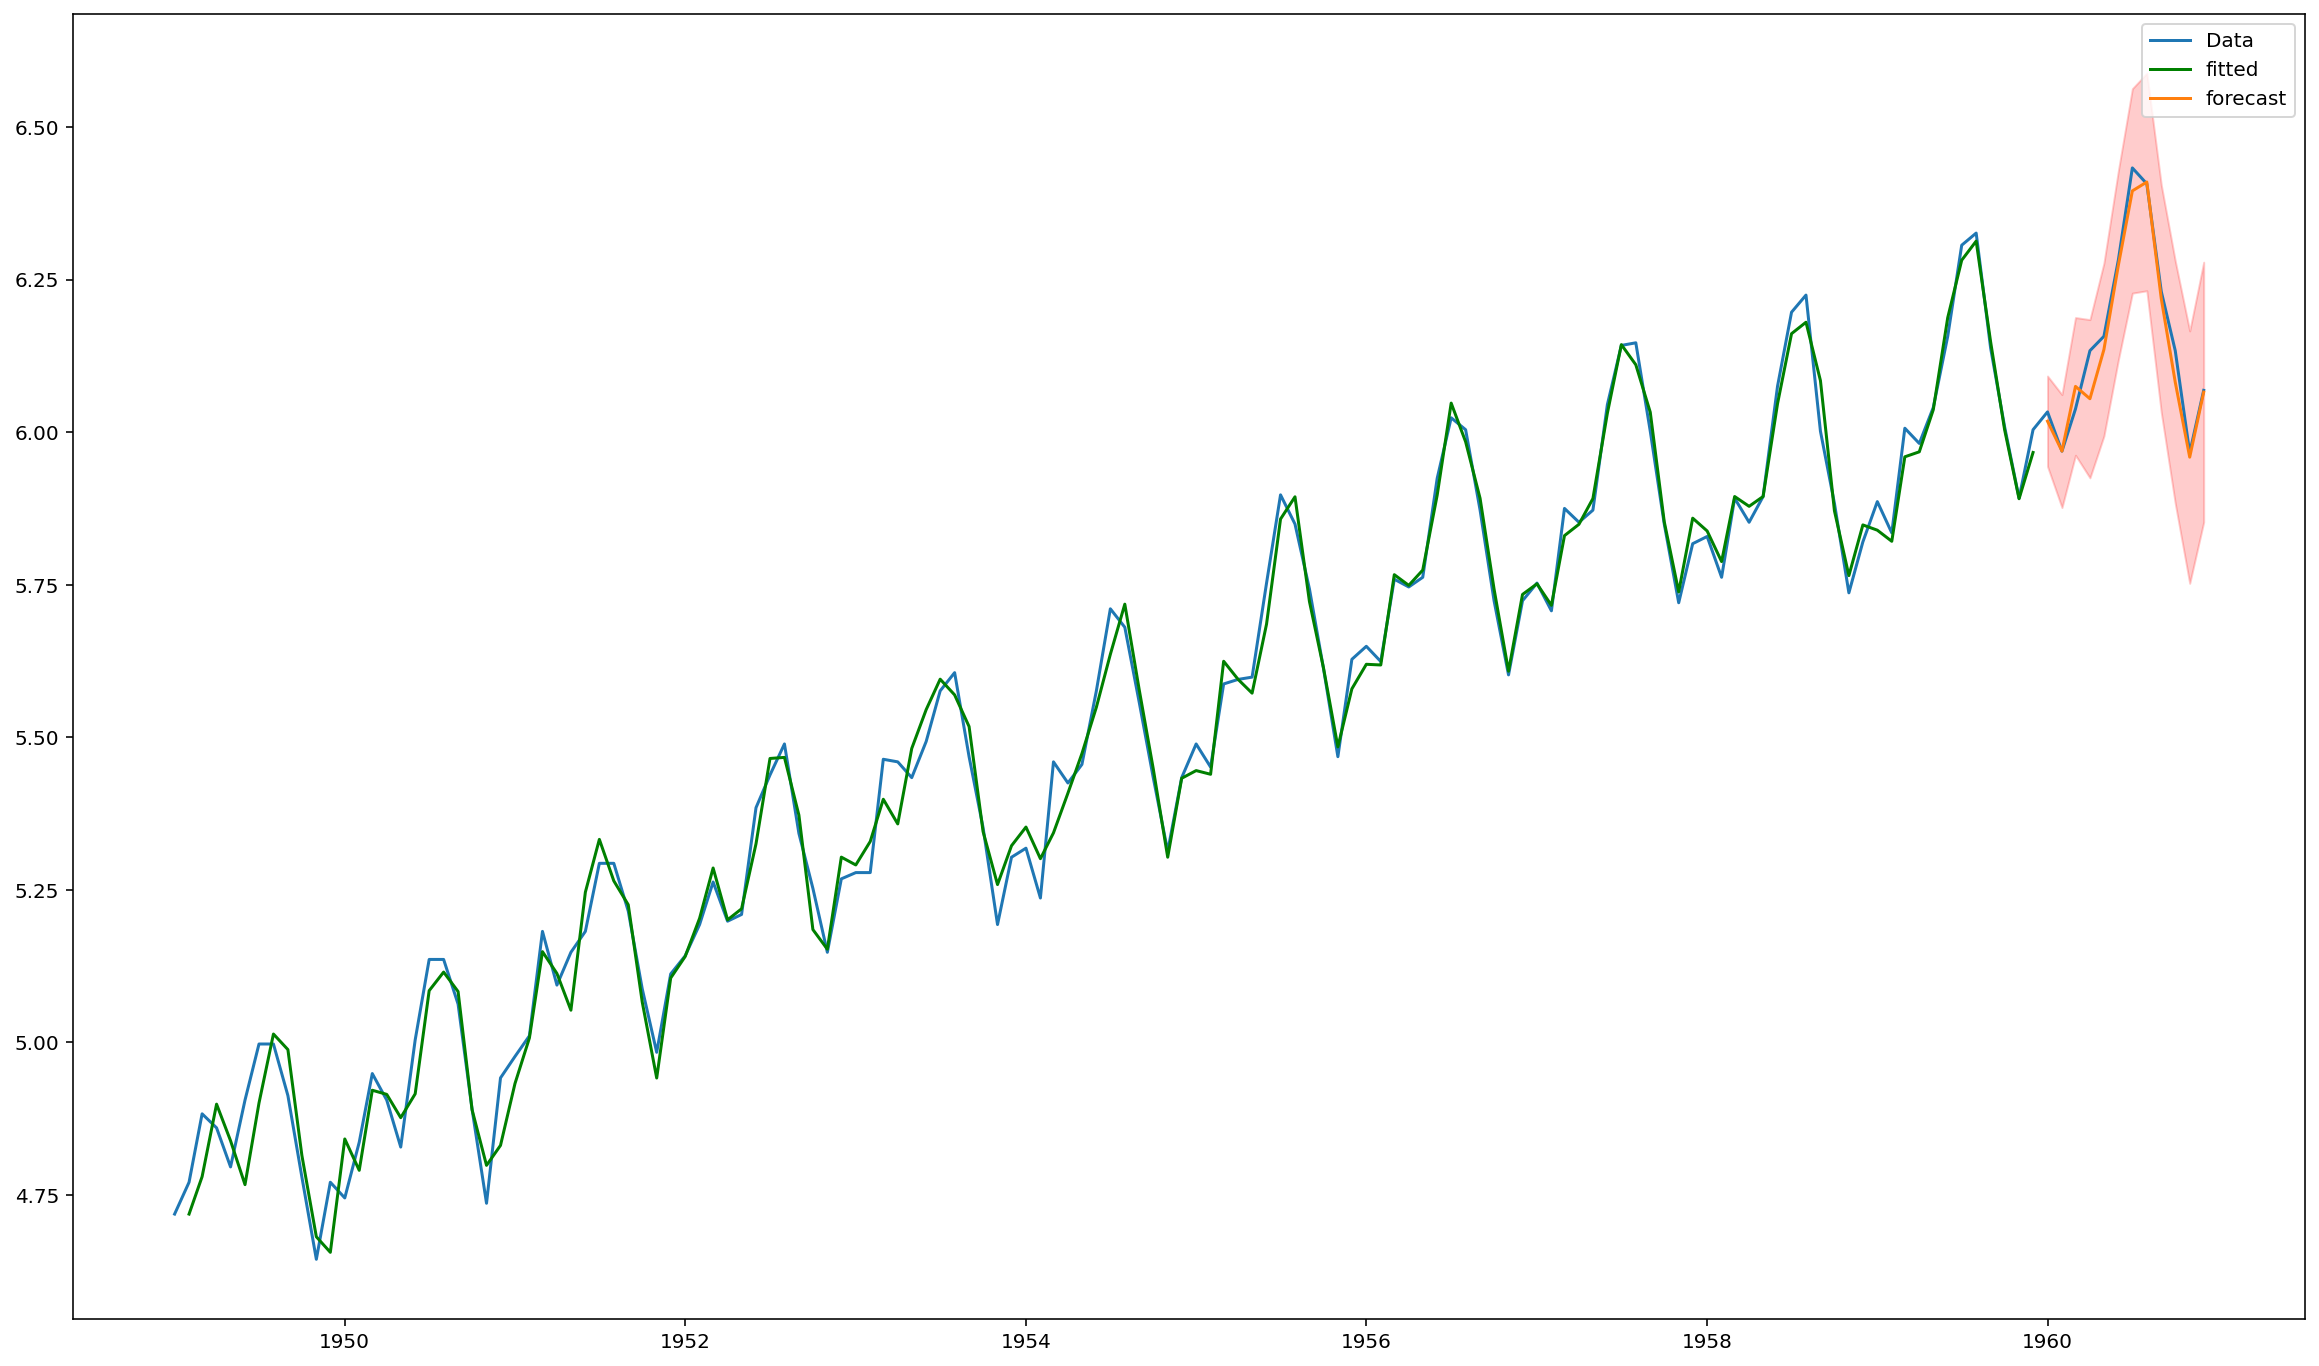

In [118]:
p = 24
d = 1
q = 0

arima = ARIMA(train['Log_Passengers'], order=(p, d, q))
arima_result = arima.fit()
plot_fit_and_forecast_int(arima_result, d, 'Log_Passengers')
print(f'ARIMA Log RMSE: {rmse(arima_result, True):.2f}')

 При p=24 т.е. на двухлетнем окне для авторегрессии ошибка получилась даже чуть меньше.